In [1]:
import folium
import branca
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import LinearRegression
from datetime import datetime
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")


In [2]:
# df_2005_2007 = pd.read_csv('modified_data_2006_2008.csv')
# df_2009_2011 = pd.read_csv('accidents_2009_to_2011.csv')
df_2012_2014 = pd.read_csv('accidents_2012_to_2014.csv')
df_combined = pd.concat([df_2012_2014], ignore_index=True)

In [3]:
filtered_df = df_combined[df_combined['LSOA_of_Accident_Location']=='E01004736']
print(filtered_df[['Longitude', 'Latitude']])
longitude_mean = filtered_df['Longitude'].mean()
longitude_range = [longitude_mean + 0.05 - 0.03, longitude_mean + 0.05 + 0.03]
print(longitude_range)
latitude_mean = filtered_df['Latitude'].mean()
latitude_range = [latitude_mean +0.02- 0.02, latitude_mean+ 0.02 + 0.02]
print(latitude_range)

        Longitude   Latitude
994     -0.127093  51.506075
995     -0.130856  51.505685
998     -0.128770  51.507361
1010    -0.126964  51.505713
1024    -0.144097  51.506076
...           ...        ...
321012  -0.133003  51.509587
321016  -0.149719  51.502478
321027  -0.133560  51.510045
321038  -0.122759  51.506366
336204  -0.123043  51.506460

[460 rows x 2 columns]
[-0.11280405217391305, -0.052804052173913055]
[51.506674697826085, 51.54667469782609]


In [4]:
df_E01004736 = df_combined[(df_combined['Longitude'] >= longitude_range[0])
                           &(df_combined['Longitude'] <= longitude_range[1])
                           &(df_combined['Latitude'] >= latitude_range[0])
                           &(df_combined['Latitude'] <= latitude_range[1])]

In [5]:
df_E01004736 = df_E01004736[(df_E01004736['Year']==2012) & (df_E01004736['Number_of_Casualties']>2)]
#location is the mean of every lat and long point to centre the map.
location = df_E01004736['Latitude'].mean(), df_E01004736['Longitude'].mean()

zoom_start = 12
#A basemap is then created using the location to centre on and the zoom level to start.
m = folium.Map(location=location,zoom_start=zoom_start)

#Each location in the DataFrame is then added as a marker to the basemap points are then added to the map
for i in range(0,len(df_E01004736)):
    folium.Marker([df_E01004736['Latitude'].iloc[i],df_E01004736['Longitude'].iloc[i]]).add_to(m)
        
m


In [6]:
# import folium.plugins as plugins

# data_heat = df_E01004736[['Latitude','Longitude','Number_of_Casualties']].values.tolist()
# m = folium.Map(location=location, zoom_start=zoom_start)
# #tiles='stamentoner'

# plugins.HeatMap(data_heat, min_opacity=0.6, radius=15, blur=10).add_to(m)

# m

## Geospatial info

In [7]:
from shapely.geometry import box, LineString
import networkx as nx 

# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest
bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# Check if bounding_box is valid
if not bounding_box.is_empty:
    # Create a GeoDataFrame with the bounding box
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
else:
    raise ValueError("The bounding box is empty!")

## road

In [8]:
shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_roads_a_free_1.shp"
df_roads = gpd.read_file(shapefile_path_1)
df_roads .head(10)
df_roads_filtered = df_roads [df_roads .intersects(bounding_box)]
df_roads_filtered.head()
print(df_roads_filtered.geometry.length)

242       0.000167
243       0.000114
245       0.000245
278       0.000659
287       0.001530
            ...   
483791    0.000128
483792    0.000091
483793    0.000064
483813    0.000340
483823    0.000444
Length: 16810, dtype: float64


In [9]:
# Set a minimum length threshold (in the same unit as your coordinate system, e.g., meters)
min_length = 0.001  # Example threshold

# Filter roads based on length
df_roads_filtered = df_roads_filtered[df_roads_filtered.geometry.length >= min_length]

print("Filtered roads with sufficient length:")
print(df_roads_filtered.head())  # Show the first few rows of the filtered roads


Filtered roads with sufficient length:
                                              geometry
287  LINESTRING (-0.08745 51.51167, -0.08773 51.512...
288  LINESTRING (-0.08514 51.5119, -0.08492 51.5118...
641  LINESTRING (-0.10593 51.53752, -0.10593 51.537...
642  LINESTRING (-0.10695 51.53751, -0.10685 51.537...
643  LINESTRING (-0.10768 51.54502, -0.1076 51.5450...


In [10]:
# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot land use regions
# df_roads_filtered.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# # Set plot title and labels
# plt.title("Land Use in Greater London")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()

In [11]:
# df_roads_filtered = df_roads [df_roads .intersects(bounding_box)]
# min_length = 0.001  # Example threshold
# df_roads_filtered = df_roads_filtered[df_roads_filtered.geometry.length >= min_length]
# fig, ax = plt.subplots(figsize=(10, 10))
# df_roads_filtered.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
# plt.title("Land Use in Greater London")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
# plt.show()

## landuse

In [12]:

# Load the shapefile
shapefile_path = 'greater-london-latest-free.shp/gis_osm_landuse_a_free_1.shp'  # Replace with your actual path
landuse = gpd.read_file(shapefile_path)
unique_land_use_types = landuse['fclass'].unique()

# Inspect the first few rows to see the data
print(unique_land_use_types)
landuse.head()

['park' 'nature_reserve' 'forest' 'industrial' 'retail'
 'recreation_ground' 'meadow' 'residential' 'cemetery' 'grass' 'scrub'
 'allotments' 'quarry' 'commercial' 'military' 'heath' 'farmland'
 'farmyard' 'orchard']


,osm_id,code,fclass,name,geometry
0,2838058,7202,park,None,"POLYGON ((-0.09186 51.66414, -0.09146 51.66418..."
1,2903046,7202,park,None,"POLYGON ((-0.08025 51.66596, -0.08005 51.6669,..."
2,2903368,7202,park,St Michael's Green,"POLYGON ((-0.08655 51.66212, -0.08653 51.66293..."
3,2903369,7202,park,None,"POLYGON ((-0.08272 51.66104, -0.08238 51.66179..."
4,2903398,7202,park,Bush Hill Park,"POLYGON ((-0.07065 51.64713, -0.07058 51.64751..."


In [13]:
df_landuse = landuse[landuse.intersects(bounding_box)]
print("Filtered landuse within Bounding Box:")
print(df_landuse.head())  # Show the first few rows of the filtered buildings

Filtered landuse within Bounding Box:
      osm_id  code             fclass                      name  \
275  4270744  7202               park  Barbican Wildlife Garden   
442  4406359  7202               park             London Fields   
496  4566319  7202               park             Sidney Square   
677  4969113  7202               park           Islington Green   
840  5070293  7211  recreation_ground       Stonebridge Gardens   

                                              geometry  
275  POLYGON ((-0.09675 51.52155, -0.0967 51.52157,...  
442  POLYGON ((-0.06305 51.54029, -0.06213 51.54046...  
496  POLYGON ((-0.05523 51.5163, -0.05519 51.51684,...  
677  POLYGON ((-0.10362 51.53582, -0.10334 51.53653...  
840  POLYGON ((-0.07541 51.53903, -0.0754 51.5392, ...  


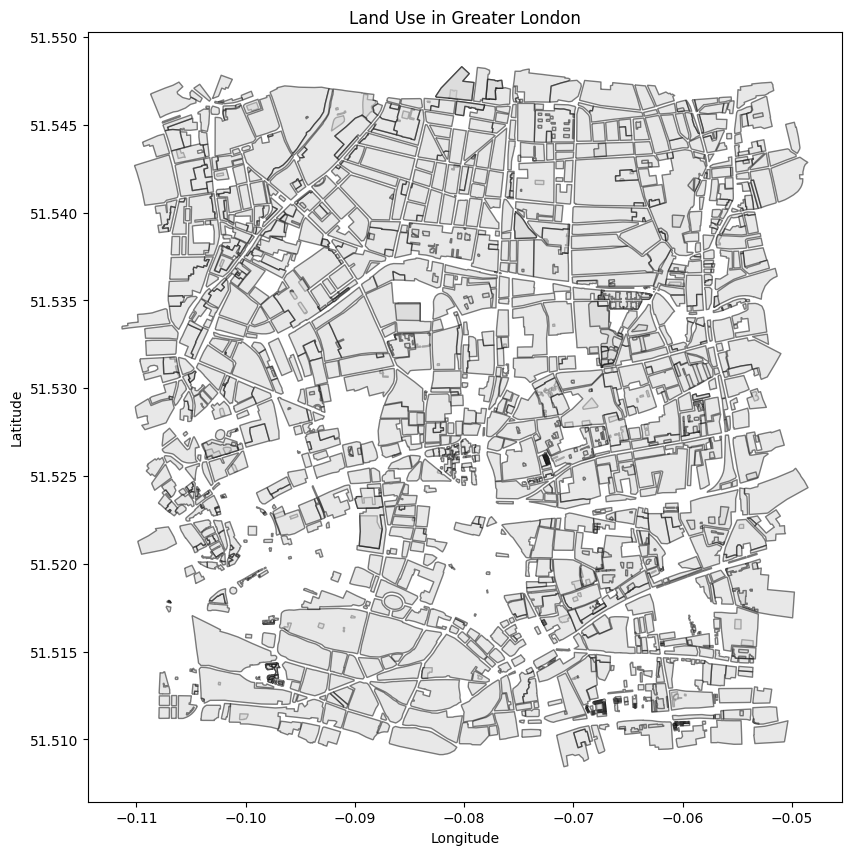

In [14]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot land use regions
df_landuse.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Set plot title and labels
plt.title("Land Use in Greater London")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


## railway

In [15]:
shapefile_path_1 = f"greater-london-latest-free.shp/gis_osm_railways_a_free_1.shp"
df_railway = gpd.read_file(shapefile_path_1)
df_railway.head(10)
df_railway_filtered = df_railway[df_railway.intersects(bounding_box)]
df_railway_filtered.head()
# # Plot the shapefile data
# fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size
# df.plot(ax=ax, color='lightgrey')  # Plot the original shapefile data
# ax.set_aspect('equal')
# # Set title and labels if needed
# plt.title("Original Shapefile Data")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()

,geometry
30,"LINESTRING (-0.06729 51.51106, -0.06687 51.511..."
38,"LINESTRING (-0.06634 51.51113, -0.06586 51.51117)"
39,"LINESTRING (-0.0643 51.52355, -0.06309 51.5236..."
40,"LINESTRING (-0.08193 51.51798, -0.08189 51.518..."
205,"LINESTRING (-0.05714 51.51173, -0.05768 51.511..."


In [16]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, box

# Load the shapefile for buildings
shapefile_path = 'greater-london-latest-free.shp/gis_osm_buildings_a_free_1.shp'  # Replace with your actual path
building = gpd.read_file(shapefile_path)

# Define key locations to preserve
key_locations_to_preserve = {
    'train_station': 5,
    'university': 4,
    'government': 3,
    "museum": 2,
    'library': 2,
    'cathedral': 2,
    "church": 1,
    "monument": 1,
    "temple": 1,
    'historic': 1,
}

# Filter the GeoDataFrame to include only key locations
filtered_building = building[building['type'].isin(key_locations_to_preserve)]
# Check if the bounding box is valid
if not bounding_box.is_empty:
    # Filter filtered_building based on the bounding box
    df_building = filtered_building[filtered_building.intersects(bounding_box)]
    print("Filtered Buildings within Bounding Box:")
    print(df_building.head())  # Show the first few rows of the filtered buildings
else:
    raise ValueError("The bounding box is empty!")

Filtered Buildings within Bounding Box:
       osm_id  code    fclass                     name           type  \
12    4076420  1500  building                St Brides         church   
115   4959629  1500  building                     None  train_station   
138   4969133  1500  building      Saint Mary's Church         church   
874  22650557  1500  building  London Fenchurch Street  train_station   
908  22883967  1500  building          Garrod Building     university   

                                              geometry  
12   POLYGON ((-0.10572 51.51387, -0.10523 51.51388...  
115  POLYGON ((-0.08273 51.51774, -0.0827 51.51778,...  
138  POLYGON ((-0.10201 51.53848, -0.10157 51.53849...  
874  POLYGON ((-0.07928 51.5115, -0.07925 51.51155,...  
908  POLYGON ((-0.06097 51.51788, -0.06052 51.51798...  


In [17]:
print(df_landuse['fclass'].unique())  # This will print all unique land use types in the dataset


['park' 'recreation_ground' 'cemetery' 'residential' 'commercial' 'forest'
 'retail' 'industrial' 'military' 'farmyard' 'grass' 'scrub' 'allotments'
 'meadow' 'orchard' 'nature_reserve']


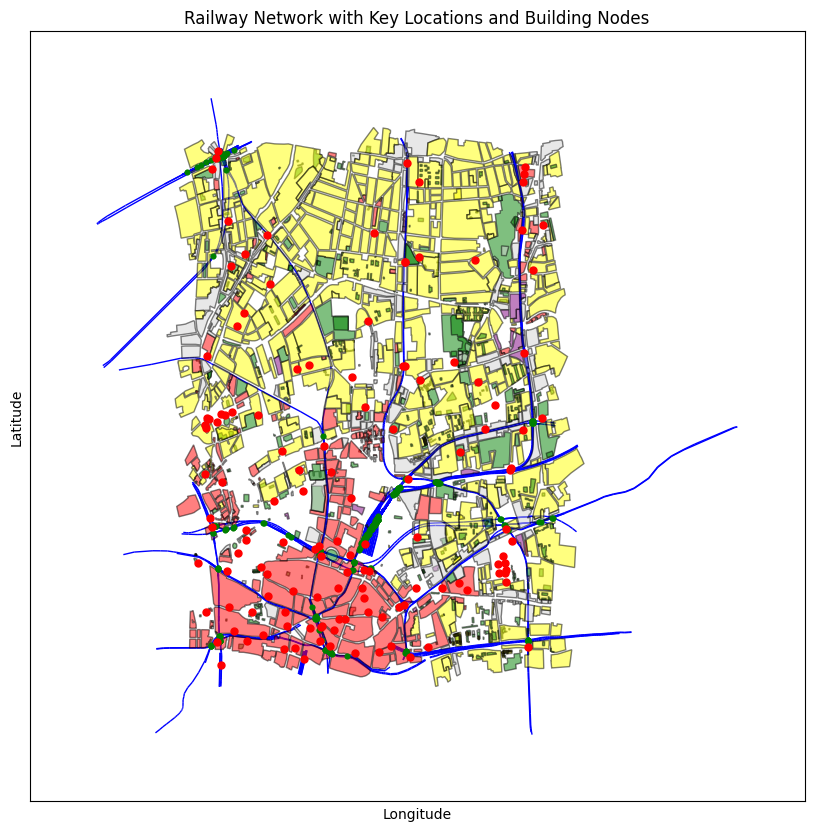

In [18]:
from shapely.geometry import Polygon  # Import the correct Polygon class
from matplotlib.patches import Polygon as MplPolygon
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point, box

# Create a new graph for the railway network
G = nx.Graph()

# Add edges to the graph from the geometries in df (assumed to be railway data)
for _, row in df_railway_filtered.iterrows():
    if isinstance(row.geometry, LineString):
        coords = list(row.geometry.coords)
        for i in range(len(coords) - 1):
            G.add_edge(coords[i], coords[i + 1], geometry=row.geometry)

# Create a simplified graph
simplified_graph = nx.Graph()

# Add simplified edges to the new graph
for edge in G.edges(data=True):
    start, end = edge[0], edge[1]
    simplified_line = LineString([start, end])
    simplified_graph.add_edge(start, end, geometry=simplified_line)

# Detect intersections
intersection_nodes = []
intersection_edges = []
for edge1 in simplified_graph.edges(data=True):
    for edge2 in simplified_graph.edges(data=True):
        if edge1 != edge2:
            line1 = edge1[2]['geometry']
            line2 = edge2[2]['geometry']
            if line1.intersects(line2):
                intersection_point = line1.intersection(line2)
                if not intersection_point.is_empty and isinstance(intersection_point, Point):
                    intersection_coords = (intersection_point.x, intersection_point.y)
                    if intersection_coords not in simplified_graph:
                        intersection_nodes.append(intersection_coords)
                        intersection_edges.append((edge1[0], intersection_coords))
                        intersection_edges.append((edge1[1], intersection_coords))
                        intersection_edges.append((edge2[0], intersection_coords))
                        intersection_edges.append((edge2[1], intersection_coords))

# Add intersection nodes and edges to the graph
for coords in intersection_nodes:
    simplified_graph.add_node(coords)

for start, end in intersection_edges:
    simplified_graph.add_edge(start, end)

# Add building nodes with weights
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    simplified_graph.add_node((centroid.x, centroid.y), weight=weight)  # Add node with weight

# Position for nodes (including intersections)
pos = {node: node for node in simplified_graph.nodes()}

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size

# Plot the network edges
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Plot intersection nodes in a different color
for coords in intersection_nodes:
    nx.draw_networkx_nodes(simplified_graph, pos, nodelist=[coords], node_color='green', node_size=10)

# Plot building nodes as red
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    ax.plot(centroid.x, centroid.y, 'ro', markersize=5)  # Plot as red nodes

# Define color mapping for each key location type
landuse_colors = {
    'commercial': 'red',
    'university': 'blue',
    'park': 'green',
    'forest': 'green',
    'recreation_ground': 'green',
    'grass': 'green',
    'residential': 'yellow',
    'industrial': 'purple',

}

# Assuming 'landuse_type' column exists in df_landuse, which corresponds to the keys in key_locations_to_preserve
for _, row in df_landuse.iterrows():
    if isinstance(row.geometry, Polygon):  # Check if it's a Polygon
        # Extract the polygon's exterior coordinates
        polygon_coords = row.geometry.exterior.coords
        
        # Get land use type from the row
        landuse_type = row['fclass']
        
        # Determine the face color based on the land use type
        facecolor = landuse_colors.get(landuse_type, 'lightgrey')  # Default color is light grey if not found
        
        # Create the polygon with the corresponding facecolor
        polygon = MplPolygon(polygon_coords, closed=True, edgecolor='black', facecolor=facecolor, alpha=0.5)
        ax.add_patch(polygon)  # Add the polygon to the plot

# Set plot title and labels
plt.title("Railway Network with Key Locations and Building Nodes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


In [19]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from shapely.geometry import Point
# import numpy as np

# # Create a new graph for the landmark network
# landmark_graph = nx.Graph()

# # Assuming df_building contains building data and key_locations_to_preserve is defined
# # Add landmark nodes to the landmark graph
# for _, row in df_building.iterrows():
#     centroid = row.geometry.centroid
#     weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
#     landmark_graph.add_node((centroid.x, centroid.y), weight=weight)  # Add landmark node with weight

# # Now, let's create edges based on nearest landmark connections
# landmark_nodes = list(landmark_graph.nodes)  # Get list of landmark nodes

# # Connect each landmark node to its nearest neighbor (or as per your logic)
# for i, node1 in enumerate(landmark_nodes):
#     for j, node2 in enumerate(landmark_nodes):
#         if i != j:  # Avoid connecting the node to itself
#             # Calculate distance
#             distance = np.linalg.norm(np.array(node1) - np.array(node2))
#             # You can define a threshold distance to add an edge
#             if distance < 1.0:  # Adjust the threshold distance as needed
#                 landmark_graph.add_edge(node1, node2, weight=distance)

# # Create a position dictionary for plotting
# pos = {node: node for node in landmark_graph.nodes()}

# # Create a plot
# fig, ax = plt.subplots(figsize=(10, 10))  # Set figure size

# # Plot landmark nodes
# nx.draw_networkx_nodes(landmark_graph, pos, node_color='orange', node_size=100)

# # Set plot title and labels
# plt.title("Landmark Graph with Key Locations")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")

# # Show the plot
# plt.show()


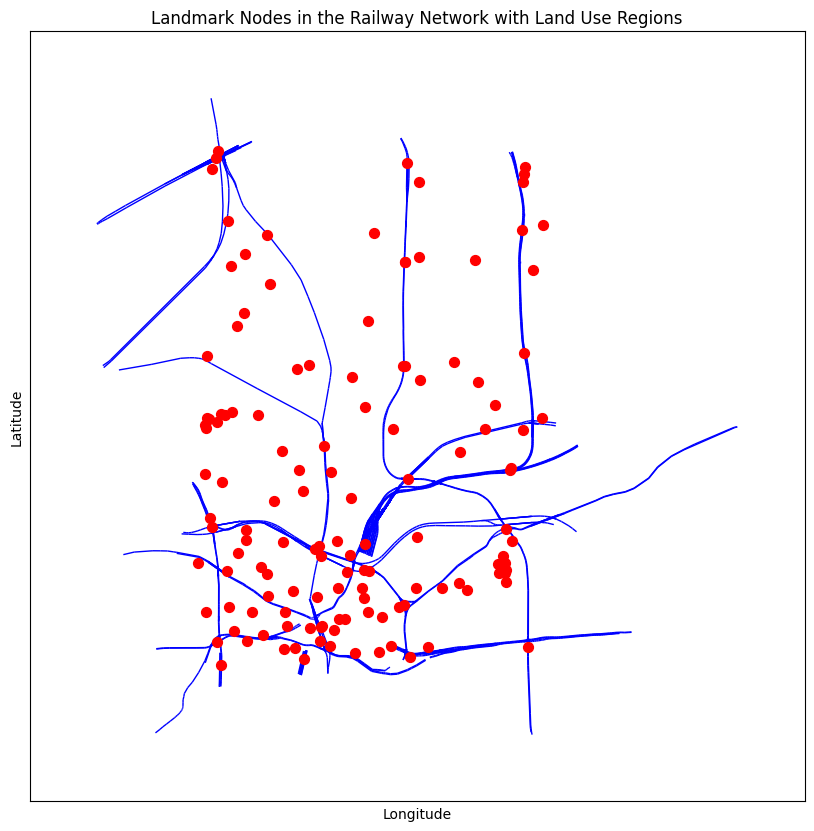

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np  # Ensure numpy is imported


# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)  # No need to loop again, landmark_nodes already has the coordinates

# Optional: Uncomment if you want to plot land use regions
# landuse_regions = []
# for _, row in df_landuse.iterrows():
#     if row.geometry is not None and row.geometry.type in ['Polygon', 'MultiPolygon']:
#         landuse_regions.append(row.geometry)

# # Plot the land use regions
# for region in landuse_regions:
#     if isinstance(region, Polygon):
#         x, y = region.exterior.xy
#         ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')
#     elif isinstance(region, MultiPolygon):
#         for poly in region.geoms:  # Use .geoms to access individual polygons
#             x, y = poly.exterior.xy
#             ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')

# Plot only the landmark nodes
nx.draw_networkx_nodes(simplified_graph, pos, nodelist=landmark_nodes, ax=ax, node_color='red', node_size=50)
# Plot the network edges
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Set plot title and labels
plt.title("Landmark Nodes in the Railway Network with Land Use Regions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()


In [21]:
print(len(simplified_graph.edges))

4263


In [22]:
import networkx as nx

# Assuming `G` is your graph created from the edges you provided

# Calculate the degree of each node
degree_dict = dict(G.degree())

# Find endpoints (nodes with degree 1)
endpoints = [node for node, degree in degree_dict.items() if degree == 1]

# Print the endpoints
print("Endpoints (nodes with only one connection):")
print(endpoints)

# If you want to find the farthest endpoint from the centroid
centroid = (-0.0672891, 51.5110622)  # Replace with your actual centroid coordinates
farthest_endpoints = sorted(endpoints, key=lambda x: np.linalg.norm(np.array(x) - np.array(centroid)), reverse=True)

# Get the four farthest endpoints
farthest_four = farthest_endpoints[:4]

print("The four endpoints farthest from the centroid are:")
print(farthest_four)


Endpoints (nodes with only one connection):
[(-0.0819261, 51.517979), (-0.0779551, 51.5114471), (-0.0777298, 51.5098131), (-0.0597635, 51.546551), (-0.0592751, 51.5465821), (-0.0760926, 51.547567), (-0.1219198, 51.5414546), (-0.1005762, 51.5470325), (-0.0254192, 51.5269379), (-0.0431718, 51.5122192), (-0.0986439, 51.5472622), (-0.1032424, 51.5084355), (-0.0757532, 51.510326), (-0.0814969, 51.5178958), (-0.0824085, 51.5180724), (-0.081433, 51.5178834), (-0.081756, 51.517946), (-0.082344, 51.5180619), (-0.0821916, 51.5180304), (-0.0821511, 51.5180226), (-0.0807988, 51.517754), (-0.1055763, 51.5101285), (-0.0784406, 51.5095608), (-0.0906354, 51.5109536), (-0.0914396, 51.5093148), (-0.090264, 51.5110118), (-0.0911399, 51.5092521), (-0.0903772, 51.5110342), (-0.0912448, 51.5092739), (-0.0907626, 51.5109748), (-0.091553, 51.5093365), (-0.090412, 51.5110406), (-0.0912924, 51.5092843), (-0.1031381, 51.5468466), (-0.0564737, 51.5051814), (-0.0816816, 51.5179348), (-0.0913899, 51.509307), (-0.09

14


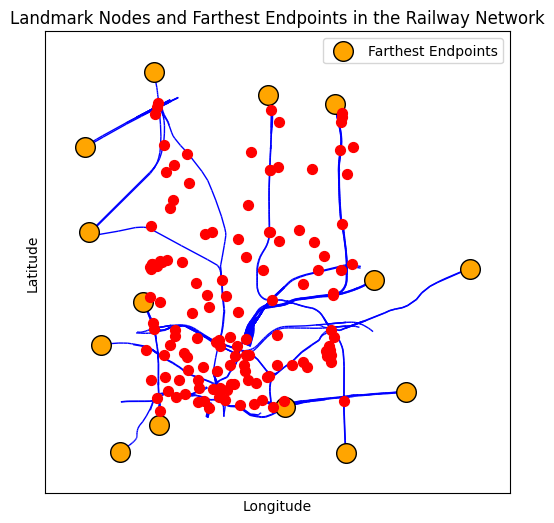

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)

# Plot the network edges
pos = {node: (node[0], node[1]) for node in simplified_graph.nodes()}  # Ensure pos is defined
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Calculate the degree of each node and find endpoints
degree_dict = dict(simplified_graph.degree())
endpoints = [node for node, degree in degree_dict.items() if degree == 1]

# Calculate the centroid of the landmark nodes for comparison
centroid = np.mean(landmark_coords, axis=0)  # Compute the centroid from landmark nodes

# Find the four farthest endpoints from the centroid
farthest_endpoints = sorted(endpoints, key=lambda x: np.linalg.norm(np.array(x) - centroid), reverse=True)

# Function to filter out overlapping points
def filter_overlapping_points(points, threshold):
    filtered_points = []
    for point in points:
        if all(np.linalg.norm(np.array(point) - np.array(existing_point)) > threshold for existing_point in filtered_points):
            filtered_points.append(point)
        if len(filtered_points) == 14:  # Stop once we have 4 points
            break
    return filtered_points

# Set a distance threshold (e.g., 0.0001 degrees for longitude/latitude)
distance_threshold = 0.01
filtered_endpoints = filter_overlapping_points(farthest_endpoints, distance_threshold)

# Plot the filtered endpoints
endpoint_coords = np.array(filtered_endpoints)
print(len(endpoint_coords))
ax.scatter(endpoint_coords[:, 0], endpoint_coords[:, 1], color='orange', s=200, label='Farthest Endpoints', edgecolor='black')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(simplified_graph, pos, nodelist=landmark_nodes, ax=ax, node_color='red', node_size=50)

# Set plot title and labels
plt.title("Landmark Nodes and Farthest Endpoints in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


24


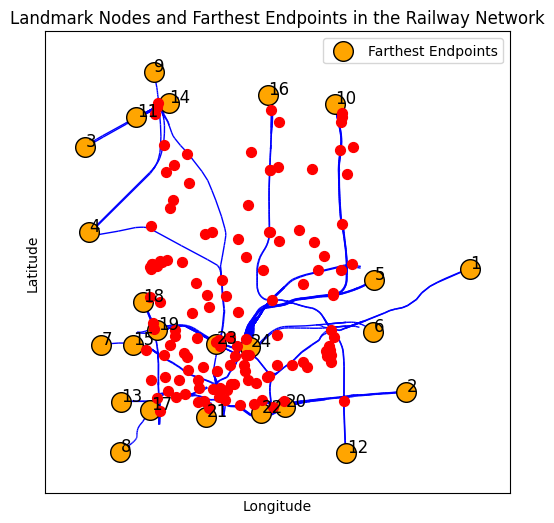

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)

# Plot the network edges
pos = {node: (node[0], node[1]) for node in simplified_graph.nodes()}  # Ensure pos is defined
nx.draw_networkx_edges(simplified_graph, pos, ax=ax, edge_color='blue', width=1)

# Calculate the degree of each node and find endpoints
degree_dict = dict(simplified_graph.degree())
endpoints = [node for node, degree in degree_dict.items() if degree == 1]

# Calculate the centroid of the landmark nodes for comparison
centroid = np.mean(landmark_coords, axis=0)  # Compute the centroid from landmark nodes

# Find the four farthest endpoints from the centroid
farthest_endpoints = sorted(endpoints, key=lambda x: np.linalg.norm(np.array(x) - centroid), reverse=True)

# Function to filter out overlapping points
def filter_overlapping_points(points, threshold):
    filtered_points = []
    for point in points:
        if all(np.linalg.norm(np.array(point) - np.array(existing_point)) > threshold for existing_point in filtered_points):
            filtered_points.append(point)
        if len(filtered_points) == 30:  # Stop once we have 4 points
            break
    return filtered_points

# Set a distance threshold (e.g., 0.0001 degrees for longitude/latitude)
distance_threshold = 0.005
filtered_endpoints = filter_overlapping_points(farthest_endpoints, distance_threshold)

# Plot the filtered endpoints
endpoint_coords = np.array(filtered_endpoints)
print(len(endpoint_coords))
ax.scatter(endpoint_coords[:, 0], endpoint_coords[:, 1], color='orange', s=200, label='Farthest Endpoints', edgecolor='black')

# Label the filtered points
for i, point in enumerate(filtered_endpoints):
    ax.text(point[0] + 0.0001, point[1] + 0.0001, f'{i+1}', fontsize=12, ha='left', color='black')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(simplified_graph, pos, nodelist=landmark_nodes, ax=ax, node_color='red', node_size=50)

# Set plot title and labels
plt.title("Landmark Nodes and Farthest Endpoints in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


In [25]:
landmark_nodes

[(-0.10547143691003925, 51.51378583350597),
 (-0.08148712130076995, 51.51860856046498),
 (-0.10170225931092795, 51.5384067777282),
 (-0.0775347437405314, 51.51132041588599),
 (-0.06065135305196608, 51.5177215864139),
 (-0.10256715465294979, 51.52780558523574),
 (-0.10320795981969214, 51.527890491295416),
 (-0.10211125675684211, 51.54167684781187),
 (-0.10450867261442078, 51.545326827918124),
 (-0.10660906431951017, 51.517268902812674),
 (-0.10223246664399493, 51.516676578222906),
 (-0.09946629804640776, 51.518922836094376),
 (-0.10359830875616209, 51.54663047786893),
 (-0.09381726696473786, 51.518714800941076),
 (-0.09575438883650518, 51.53715922528605),
 (-0.09765400037194773, 51.52778720369907),
 (-0.0940034, 51.525216),
 (-0.09960505533587923, 51.53928487425357),
 (-0.07380499596644939, 51.51546790389022),
 (-0.10562234014514855, 51.523575623279676),
 (-0.10074851064957079, 51.53413665543278),
 (-0.10534427083765845, 51.53198552919702),
 (-0.05615996220225827, 51.53817540010842),
 (

## k-Means clustering for landmark

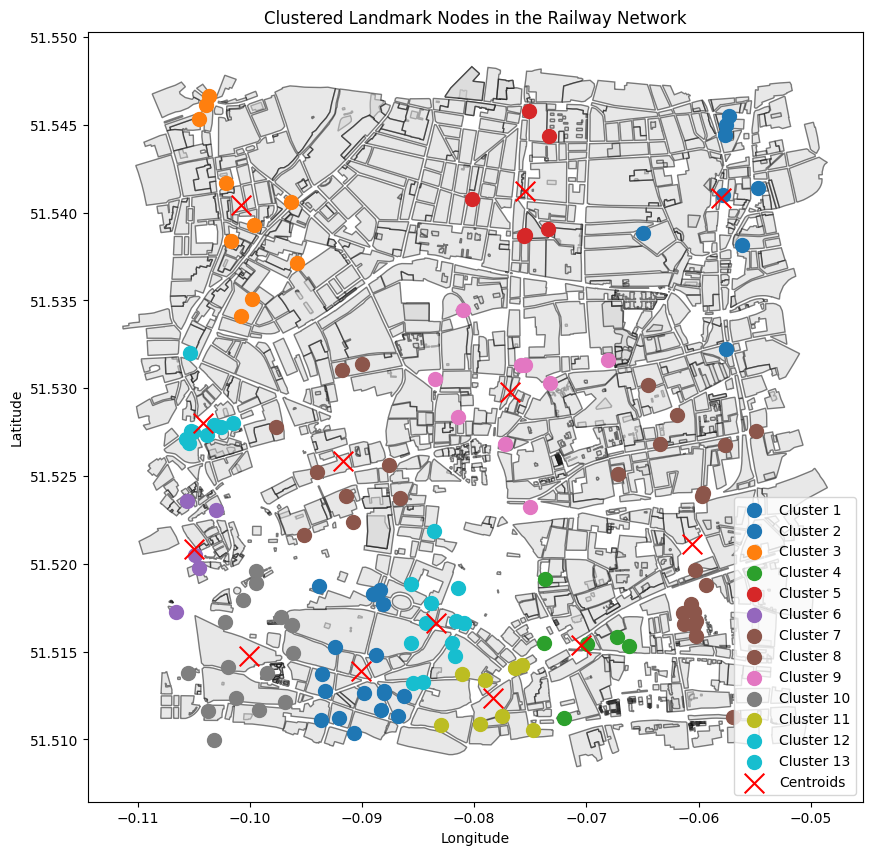

In [26]:
import matplotlib.pyplot as plt
import networkx as nx
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
from sklearn.cluster import KMeans  # Import KMeans for clustering

# Create a plot
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Create a list to store landmark nodes
landmark_nodes = []

# Iterate through df_building to add only landmark nodes
for _, row in df_building.iterrows():
    centroid = row.geometry.centroid
    weight = key_locations_to_preserve[row['type']]  # Assign weight based on building type
    landmark_nodes.append((centroid.x, centroid.y))  # Store landmark coordinates as tuples
    simplified_graph.add_node((centroid.x, centroid.y), landmark_type=row['type'])

# Create a NumPy array for landmark coordinates
landmark_coords = np.array(landmark_nodes)

# Step 1: Cluster the landmark nodes into clusters
num_clusters = 13
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(landmark_coords)

# Step 2: Get cluster labels
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Optional: Uncomment if you want to plot land use regions
landuse_regions = []
for _, row in df_landuse.iterrows():
    if row.geometry is not None and row.geometry.type in ['Polygon', 'MultiPolygon']:
        landuse_regions.append(row.geometry)

# Plot the land use regions
for region in landuse_regions:
    if isinstance(region, Polygon):
        x, y = region.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')
    elif isinstance(region, MultiPolygon):
        for poly in region.geoms:  # Use .geoms to access individual polygons
            x, y = poly.exterior.xy
            ax.fill(x, y, alpha=0.5, fc='lightgrey', edgecolor='black')

# Step 3: Plot the landmark nodes with colors based on cluster labels
colors = plt.cm.get_cmap('tab10', num_clusters)  # Get a colormap with as many colors as clusters
for cluster in range(num_clusters):
    cluster_nodes = landmark_coords[labels == cluster]
    ax.scatter(cluster_nodes[:, 0], cluster_nodes[:, 1], 
               color=colors(cluster), label=f'Cluster {cluster + 1}', s=100)
    
ax.scatter(centroids[:, 0], centroids[:, 1], color='red', marker='x', s=200, label='Centroids')

# Construct the pos dictionary for the graph
pos = {node: (node[0], node[1]) for node in simplified_graph.nodes()}

# Set plot title and labels
plt.title("Clustered Landmark Nodes in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


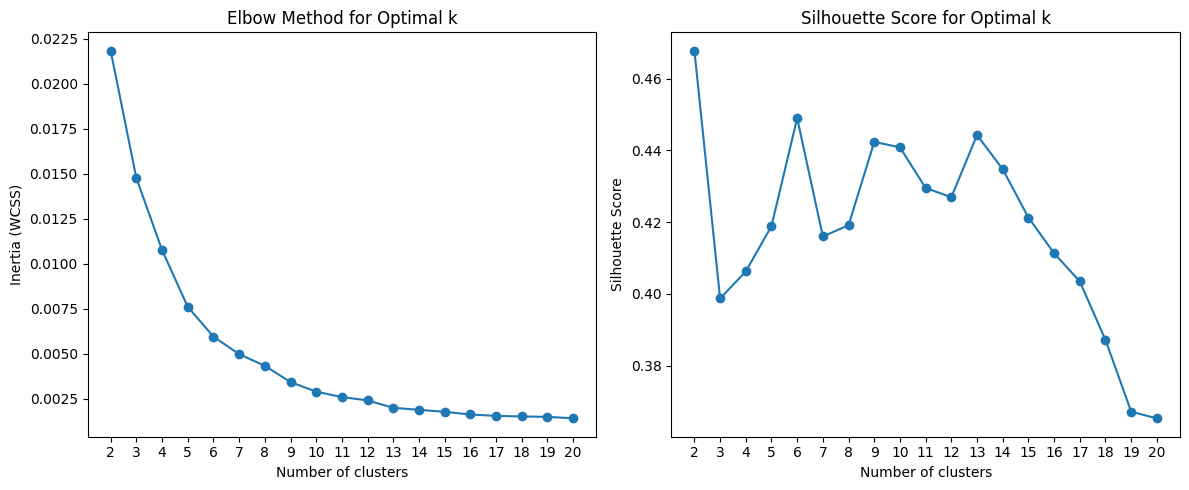

In [27]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Assuming landmark_coords is your array of landmark coordinates
range_n_clusters = range(2, 21)  # Test cluster numbers from 2 to 10

# Initialize lists to hold the results
inertia = []
silhouette_scores = []

# Calculate inertia and silhouette scores
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(landmark_coords)
    
    inertia.append(kmeans.inertia_)  # WCSS
    silhouette_avg = silhouette_score(landmark_coords, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(12, 5))

# Subplot for Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (WCSS)')
plt.xticks(range_n_clusters)

# Subplot for Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters)

plt.tight_layout()
plt.show()


### Mathematical Formulation for Optimization Score

The optimization score is calculated based on the following components:

1. **Total Distance of the Path:**

   The total distance \( D \) of the path is computed as the sum of the weights of all edges in the path. If we denote the path as \( P = (p_0, p_1, \ldots, p_n) \), then the total distance can be expressed as:

   \[
   D = \sum_{i=0}^{n-1} w(p_i, p_{i+1})
   \]

   where \( w(p_i, p_{i+1}) \) is the weight of the edge connecting nodes \( p_i \) and \( p_{i+1} \) in the graph.

2. **Number of Connected Nodes:**

   The number of unique nodes \( C \) in the path can be represented as:

   \[
   C = | \{ p_0, p_1, \ldots, p_n \} |
   \]

   where \( | \cdot | \) denotes the cardinality (the number of unique elements) of the set of nodes in the path.

3. **Average Distance to Centroids:**

   The average distance \( A \) from each node in the path to the nearest K-means centroid can be computed as:

   \[
   A = \frac{1}{n} \sum_{j=0}^{n} \min_{C_i \in C} \left( \| p_j - C_i \| \right)
   \]

   where \( C \) is the set of centroids, \( C_i \) represents each centroid, and \( \| p_j - C_i \| \) is the Euclidean distance between the node \( p_j \) and the centroid \( C_i \).

### Final Optimization Score Formula

Combining all the components, the overall optimization score \( S \) can be represented as:

\[
S = (1 - \beta) \cdot D + \beta \cdot C - A
\]

where \( \beta \) is a weight factor (ranging from 0 to 1) that determines the relative importance of the number of connected nodes compared to the total distance of the path.


Optimized Path: [(-0.0253973, 51.5269642), (-0.05490464539601196, 51.52756878205618), (-0.06447214999999826, 51.53019055000001), (-0.07323553216240178, 51.53028795485744), (-0.07581521437499834, 51.53131862775487), (-0.08351835786006821, 51.53053537766514), (-0.08998067030559856, 51.5313646592414), (-0.09575438883650518, 51.53715922528605), (-0.10211125675684211, 51.54167684781187), (-0.10450867261442078, 51.545326827918124), (-0.1219198, 51.5414546)]
Optimization Score: 0.8494216701685939


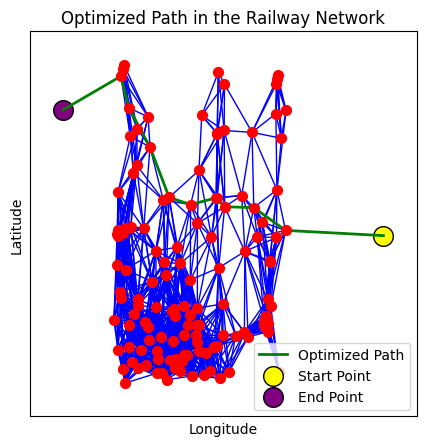

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create a graph from landmark nodes
landmark_graph = nx.Graph()

# Add landmark nodes to the graph as tuples
for landmark in landmark_nodes:
    landmark_graph.add_node(tuple(landmark))  # Convert to tuple

# Define a scaling factor for edge weights
scaling_factor = 10  # Adjust this value as needed to increase the weights

# Create edges between landmark nodes based on a distance threshold
distance_threshold = 0.01  # Adjust as necessary
for i, landmark1 in enumerate(landmark_nodes):
    for landmark2 in landmark_nodes[i + 1:]:
        distance = np.linalg.norm(np.array(landmark1) - np.array(landmark2))
        if distance <= distance_threshold:
            weighted_distance = distance * scaling_factor  # Scale the distance
            landmark_graph.add_edge(tuple(landmark1), tuple(landmark2), weight=weighted_distance)  # Convert to tuple

# Select start and end points maximizing distance
start_point, end_point = None, None
max_distance = 0

for i in range(len(filtered_endpoints)):
    for j in range(i + 1, len(filtered_endpoints)):
        distance = np.linalg.norm(np.array(filtered_endpoints[i]) - np.array(filtered_endpoints[j]))
        if distance > max_distance:
            max_distance = distance
            start_point, end_point = filtered_endpoints[i], filtered_endpoints[j]

# Add start and end points to the graph and connect to the nearest landmark nodes
def connect_nearest(landmark_graph, point):
    nearest_node = min(landmark_nodes, key=lambda node: np.linalg.norm(np.array(point) - np.array(node)))
    distance = np.linalg.norm(np.array(point) - np.array(nearest_node))
    weighted_distance = distance * scaling_factor  # Scale the distance
    landmark_graph.add_edge(tuple(point), tuple(nearest_node), weight=weighted_distance)  # Convert to tuple

connect_nearest(landmark_graph, tuple(start_point))
connect_nearest(landmark_graph, tuple(end_point))

# Find the shortest path using Dijkstra's algorithm
try:
    path = nx.dijkstra_path(landmark_graph, tuple(start_point), tuple(end_point))
except nx.NetworkXNoPath:
    print("No path found between the start and end points.")
    path = []

# Calculate optimization criteria
def optimization_score(path, start_point, end_point):
    if len(path) < 2:
        return 0  # No valid path found
    path_length = 0
    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        if edge in landmark_graph.edges:
            path_length += landmark_graph[edge[0]][edge[1]]['weight']
    connected_landmark_nodes = len(path) - 2  # Exclude start and end points
    distance = np.linalg.norm(np.array(start_point) - np.array(end_point))
    return (connected_landmark_nodes * distance) / path_length if path_length > 0 else 0

# Calculate score for the found path
score = optimization_score(path, start_point, end_point)

# Print results
print("Optimized Path:", path)
print("Optimization Score:", score)

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))  # Adjust figure size as needed

# Plot the network edges
pos = {node: (node[0], node[1]) for node in landmark_graph.nodes()}  # Ensure pos is defined
nx.draw_networkx_edges(landmark_graph, pos, ax=ax, edge_color='blue', width=1)

# Plot the optimized path if found
if path:
    path_coords = np.array(path)
    ax.plot(path_coords[:, 0], path_coords[:, 1], color='green', linewidth=2, label='Optimized Path')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='red', node_size=50)

# Highlight start and end points
ax.scatter(start_point[0], start_point[1], color='yellow', s=200, label='Start Point', edgecolor='black')
ax.scatter(end_point[0], end_point[1], color='purple', s=200, label='End Point', edgecolor='black')

# Set plot title and labels
plt.title("Optimized Path in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()


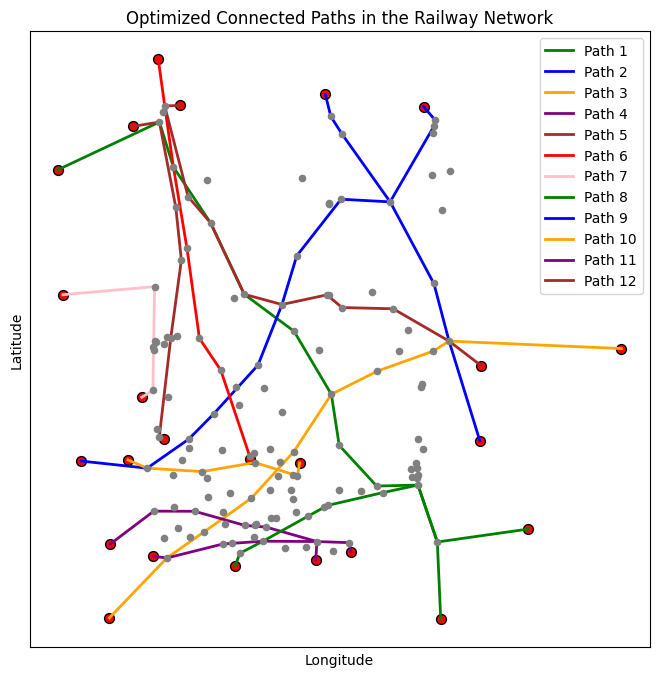

Connected Path 1: [(-0.0413418, 51.5123328), (-0.05691543642696273, 51.5112852598348), (-0.06023290028409142, 51.51589934999195), (-0.06730209565642328, 51.51582080236443), (-0.0737149643355573, 51.519113811700294), (-0.07506179231117928, 51.52325832870609), (-0.08145861079818892, 51.52836953774279), (-0.08998067030559856, 51.5313646592414), (-0.09575438883650518, 51.53715922528605), (-0.10211125675684211, 51.54167684781187), (-0.10450867261442078, 51.545326827918124), (-0.1219198, 51.5414546)]
Connected Path 2: [(-0.1179229, 51.517846), (-0.10660906431951017, 51.517268902812674), (-0.09949279154053142, 51.519619757855914), (-0.09521066140795463, 51.521670977176115), (-0.0876268, 51.52562374999999), (-0.08351835786006821, 51.53053537766514), (-0.08099011842471938, 51.534480617770576), (-0.07340203400518815, 51.53907059828214), (-0.06499567308553308, 51.53885566185226), (-0.05751748518150304, 51.54496919044617), (-0.0573163852568348, 51.545497212231844), (-0.0592751, 51.5465821)]
Connec

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from itertools import combinations
from sklearn.cluster import KMeans
import random

# Function to calculate distance to the nearest K-means centroid
def distance_to_centroid(node, centroids):
    return np.min([np.linalg.norm(np.array(node) - np.array(centroid)) for centroid in centroids])

# Function to find optimized path between two points
def find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges):
    # Connect start and end points to the nearest landmark nodes
    connect_nearest(landmark_graph, tuple(start_point))
    connect_nearest(landmark_graph, tuple(end_point))
    
    # Find the shortest path using Dijkstra's algorithm
    try:
        path = nx.dijkstra_path(landmark_graph, tuple(start_point), tuple(end_point))
    except nx.NetworkXNoPath:
        return [], 0  # No path found

    # Calculate optimization score using the new criteria
    score = optimization_score(path, start_point, end_point, centroids, used_edges)
    return path, score

# Function to check if an edge is diagonal
def is_diagonal(edge):
    node1, node2 = edge
    return not (node1[0] == node2[0] or node1[1] == node2[1])

# Function to check if two edges intersect
def edges_intersect(edge1, edge2):
    # Check if two line segments (edges) intersect
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    A, B = edge1
    C, D = edge2
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

# Optimization score calculation with vertical/horizontal priority and intersection avoidance
def optimization_score(path, start_point, end_point, centroids, used_edges, omega=0.2, beta=2, alpha=0.5, delta=0.2, gamma=1, epsilon=1):
    distance = 0
    overlap_penalty = 0
    diagonal_penalty = 0
    intersection_penalty = 0

    # List of edges that were added in this path to check for intersections
    new_edges = []

    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        reverse_edge = (path[i + 1], path[i])

        if edge in landmark_graph.edges:
            distance += landmark_graph.edges[edge]['weight']  # Directly access the edge weight

            # Penalize diagonal movement
            if is_diagonal(edge):
                diagonal_penalty += 1

            # Check for overlap penalties
            if edge in used_edges or reverse_edge in used_edges:
                overlap_penalty += 1  # Increment penalty for overlapping edge

            # Check for intersection with previous edges
            for prev_edge in used_edges:
                if edges_intersect(edge, prev_edge):
                    intersection_penalty += 1  # Increment penalty for intersecting another path

            # Add the edge to the list of new edges
            new_edges.append(edge)
        else:
            print(f"Edge not found: {edge}. Using default distance of infinity.")
            distance = float('inf')  # Handle missing edges appropriately
            break

    # Calculate the number of unique nodes in the path and average distance to centroids
    connected_nodes = len(set(path))  # Unique nodes in the path
    avg_distance_to_centroid = np.mean([distance_to_centroid(node, centroids) for node in path])

    # Return a score that prioritizes short, non-diagonal, non-intersecting paths
    return (
        omega * distance +  # Prioritize minimizing distance
        beta * connected_nodes -  # Encourage more connected nodes
        alpha * avg_distance_to_centroid -  # Penalize based on distance to centroids
        delta * overlap_penalty -  # Penalize overlapping edges
        gamma * diagonal_penalty -  # Penalize diagonal movement
        epsilon * intersection_penalty  # Penalize intersections
    )


# Initialize all points (filtered_endpoints) to connect
remaining_points = filtered_endpoints.copy()
connected_paths = []  # Store the paths that connect points
used_edges = set()  # To track used edges

# While there are still points left to connect
while len(remaining_points) > 1:
    best_path = None
    best_score = -np.inf  # Initialize to negative infinity for maximization
    
    # Check combinations of all remaining points
    for combination in combinations(remaining_points, 2):
        start_point, end_point = combination
        path, score = find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges)
        
        # Update the best path if the current one has a higher score
        if score > best_score:
            best_path = path
            best_score = score
            
    if best_path:  # If a valid best path was found
        connected_paths.append(best_path)
        # Add used edges and their reverse to the set
        for i in range(len(best_path) - 1):
            used_edges.add((best_path[i], best_path[i + 1]))
            used_edges.add((best_path[i + 1], best_path[i]))  # Include reverse edge
        
        # Remove the points that have been connected
        connected_set = set(best_path)
        remaining_points = [point for point in remaining_points if tuple(point) not in connected_set]

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

# Plot the network edges
pos = {node: (node[0], node[1]) for node in landmark_graph.nodes()}  # Ensure pos is defined

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red', 'pink'] 

# Plot the connected paths
for i, path in enumerate(connected_paths):
    path_coords = np.array(path)
    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(path_coords[:, 0], path_coords[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Optimized Connected Paths in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Print the connected paths
for i, path in enumerate(connected_paths):
    print(f"Connected Path {i + 1}: {path}")

# Function to connect nearest nodes (implement this as needed)
def connect_nearest(landmark_graph, point):
    # Find the nearest landmark node to connect
    nearest_node = min(landmark_graph.nodes, key=lambda node: np.linalg.norm(np.array(node) - np.array(point)))
    landmark_graph.add_edge(point, nearest_node, weight=np.linalg.norm(np.array(point) - np.array(nearest_node)))

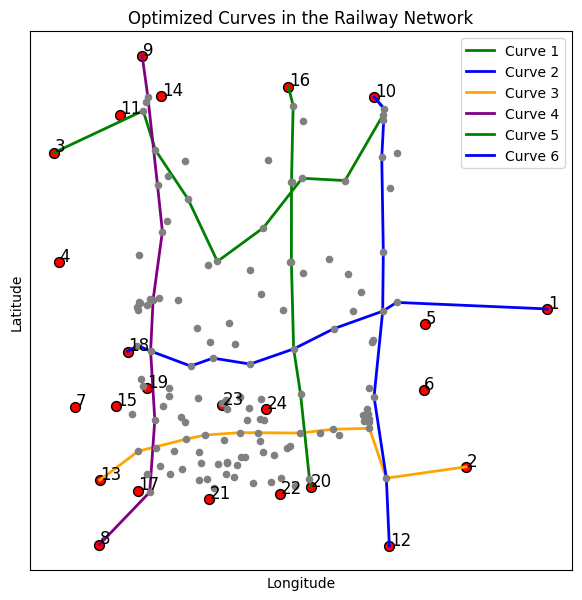

Curve 1: [(-0.1219198, 51.5414546), (-0.10450867261442078, 51.545326827918124), (-0.10211125675684211, 51.54167684781187), (-0.09575438883650518, 51.53715922528605), (-0.08998067030559856, 51.5313646592414), (-0.08099011842471938, 51.534480617770576), (-0.07340203400518815, 51.53907059828214), (-0.06499567308553308, 51.53885566185226), (-0.05751748518150304, 51.54496919044617), (-0.0573163852568348, 51.545497212231844), (-0.0592751, 51.5465821)]
Curve 2: [(-0.1075325, 51.5230171), (-0.10562234014514855, 51.523575623279676), (-0.10305374888182217, 51.523058895515994), (-0.09521066140795463, 51.521670977176115), (-0.09084355699294575, 51.52240925293738), (-0.08359186811972005, 51.52185419342645), (-0.07506179231117928, 51.52325832870609), (-0.06716922162682053, 51.525139597483125), (-0.057634992763566616, 51.526753316559585), (-0.05490464539601196, 51.52756878205618), (-0.0253973, 51.5269642)]
Curve 3: [(-0.1129554, 51.5111109), (-0.10547143691003925, 51.51378583350597), (-0.096118043985

In [30]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from itertools import combinations

random.seed = 7

# Function to calculate distance to the nearest K-means centroid
def distance_to_centroid(node, centroids):
    return np.min([np.linalg.norm(np.array(node) - np.array(centroid)) for centroid in centroids])

# Function to find optimized path between two points
def find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges):
    # Connect start and end points to the nearest landmark nodes
    connect_nearest(landmark_graph, tuple(start_point))
    connect_nearest(landmark_graph, tuple(end_point))
    
    # Find the shortest path using Dijkstra's algorithm
    try:
        path = nx.dijkstra_path(landmark_graph, tuple(start_point), tuple(end_point))
    except nx.NetworkXNoPath:
        return [], 0  # No path found

    # Calculate optimization score using the new criteria
    score = optimization_score(path, start_point, end_point, centroids, used_edges)
    return path, score

# Function to check if an edge is diagonal
def is_diagonal(edge):
    node1, node2 = edge
    return not (node1[0] == node2[0] or node1[1] == node2[1])

# Function to check if two edges intersect
def edges_intersect(edge1, edge2):
    # Check if two line segments (edges) intersect
    def ccw(A, B, C):
        return (C[1] - A[1]) * (B[0] - A[0]) > (B[1] - A[1]) * (C[0] - A[0])

    A, B = edge1
    C, D = edge2
    return ccw(A, C, D) != ccw(B, C, D) and ccw(A, B, C) != ccw(A, B, D)

# Optimization score calculation with vertical/horizontal priority and intersection avoidance
def optimization_score(path, start_point, end_point, centroids, used_edges, omega=10, beta=2, alpha=0.5, delta=1, gamma=0, epsilon=0):
    distance = 0
    overlap_penalty = 0
    diagonal_penalty = 0
    intersection_penalty = 0

    # List of edges that were added in this path to check for intersections
    new_edges = []

    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        reverse_edge = (path[i + 1], path[i])

        if edge in landmark_graph.edges:
            distance += landmark_graph.edges[edge]['weight']  # Directly access the edge weight

            # Penalize diagonal movement
            if is_diagonal(edge):
                diagonal_penalty += 1

            # Check for overlap penalties
            if edge in used_edges or reverse_edge in used_edges:
                overlap_penalty += 1  # Increment penalty for overlapping edge

            # Check for intersection with previous edges
            for prev_edge in used_edges:
                if edges_intersect(edge, prev_edge):
                    intersection_penalty += 1  # Increment penalty for intersecting another path

            # Add the edge to the list of new edges
            new_edges.append(edge)
        else:
            print(f"Edge not found: {edge}. Using default distance of infinity.")
            distance = float('inf')  # Handle missing edges appropriately
            break

    # Calculate the number of unique nodes in the path and average distance to centroids
    connected_nodes = len(set(path))  # Unique nodes in the path
    avg_distance_to_centroid = np.mean([distance_to_centroid(node, centroids) for node in path])

    # Return a score that prioritizes short, non-diagonal, non-intersecting paths
    return (
        omega * distance +  # Prioritize minimizing distance
        beta * connected_nodes -  # Encourage more connected nodes
        alpha * avg_distance_to_centroid -  # Penalize based on distance to centroids
        delta * overlap_penalty -  # Penalize overlapping edges
        gamma * diagonal_penalty -  # Penalize diagonal movement
        epsilon * intersection_penalty  # Penalize intersections
    )

# Function to connect nearest nodes (implement this as needed)
def connect_nearest(landmark_graph, point):
    # Find the nearest landmark node to connect
    nearest_node = min(landmark_graph.nodes, key=lambda node: np.linalg.norm(np.array(node) - np.array(point)))
    landmark_graph.add_edge(point, nearest_node, weight=np.linalg.norm(np.array(point) - np.array(nearest_node)))

# Initialize used_edges and centroids
used_edges = set()  # To track used edges
centroids = np.array([centroid for centroid in landmark_graph.nodes])  # Adjust as needed

# Define the start and end points for each curve
start_end_points = [
    (filtered_endpoints[3-1], filtered_endpoints[10-1]), 
    (filtered_endpoints[18-1], filtered_endpoints[1-1]),  
    # (filtered_endpoints[7-1], filtered_endpoints[5-1]), 
    (filtered_endpoints[13-1], filtered_endpoints[2-1]),
    (filtered_endpoints[9-1], filtered_endpoints[8-1]),
    (filtered_endpoints[16-1], filtered_endpoints[20-1]),
    (filtered_endpoints[10-1], filtered_endpoints[12-1])
]

connected_paths = []  # Store the paths that connect points

# For each start and end point pair, find the optimized path
for start_point, end_point in start_end_points:
    path, score = find_optimized_path(start_point, end_point, landmark_graph, centroids, used_edges)
    if path:
        connected_paths.append(path)
        # Add used edges and their reverse to the set
        for i in range(len(path) - 1):
            used_edges.add((path[i], path[i + 1]))
            used_edges.add((path[i + 1], path[i]))  # Include reverse edge

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(7, 7))  # Adjust figure size as needed

# Plot the network edges
pos = {node: (node[0], node[1]) for node in landmark_graph.nodes()}  # Ensure pos is defined

colors = ['green', 'blue', 'orange', 'purple']  # Color for each curve

# Plot the connected paths
for i, path in enumerate(connected_paths):
    path_coords = np.array(path)
    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(path_coords[:, 0], path_coords[:, 1], color=color, linewidth=2, label=f'Curve {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points and plot labels
for i, point in enumerate(filtered_endpoints):
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')
    ax.text(point[0] + 0.0001, point[1] + 0.0001, f'{i+1}', fontsize=12, ha='left', color='black')

# Set plot title and labels
plt.title("Optimized Curves in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Print the connected paths
for i, path in enumerate(connected_paths):
    print(f"Curve {i + 1}: {path}")


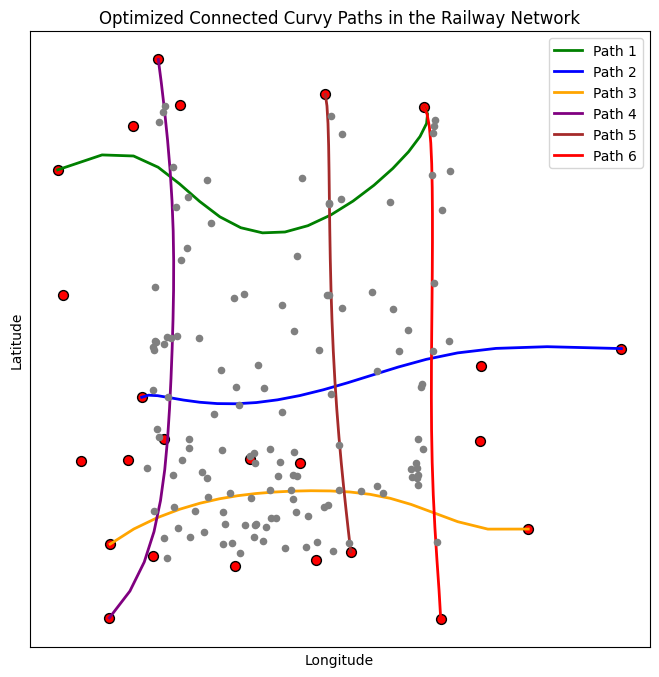

Smooth Paths List:
Path 1:
x: [-0.1219198  -0.11433048 -0.10893797 -0.10472809 -0.10107926 -0.09762285
 -0.09415352 -0.09057218 -0.08684945 -0.0830027  -0.07908222 -0.07516398
 -0.07134716 -0.06775444 -0.06453216 -0.06184669 -0.0598715  -0.0587585
 -0.05858604 -0.0592751 ], y: [51.5414546  51.54266159 51.54257512 51.54166337 51.54032337 51.53889356
 51.53764352 51.53676057 51.53634442 51.53641394 51.5369248  51.53779334
 51.53892031 51.54020818 51.54156793 51.54291508 51.54416067 51.5452108
 51.54599832 51.5465821 ]
Path 2:
x: [-0.1075325  -0.10638318 -0.1048127  -0.1027832  -0.10035617 -0.09760868
 -0.09459945 -0.09136304 -0.08791733 -0.08427421 -0.08044792 -0.07645754
 -0.07232169 -0.0680436  -0.06358315 -0.0588106  -0.05343259 -0.04687665
 -0.03811449 -0.0253973 ], y: [51.5230171  51.52318425 51.52314509 51.52298615 51.52278823 51.52261322
 51.52250409 51.52248931 51.52258729 51.52280853 51.52315548 51.52362077
 51.52418519 51.52481651 51.52546985 51.52608987 51.52661439 51.52697819

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb

# Function to create Bézier curves
def bezier_curve(points, num_points=20):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths

# Plot the connected paths with Bézier curves
for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)
    
    # Store the smoothed path in the list as a tuple
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Optional: Plot only the landmark nodes
nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Optimized Connected Curvy Paths in the Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth paths
print("Smooth Paths List:")
for idx, path in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')


## landuse region

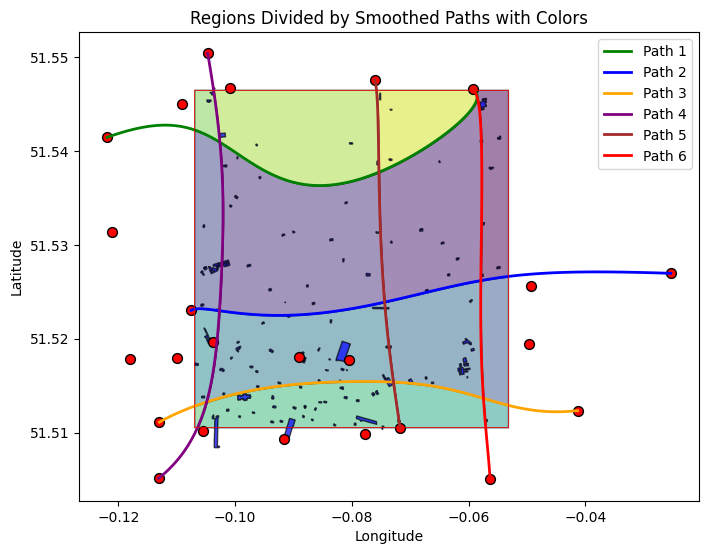

Smooth Paths List:
Path 1:
x: [-0.1219198  -0.12022774 -0.11866016 -0.11720471 -0.1158501  -0.11458598
 -0.11340291 -0.11229224 -0.11124609 -0.11025727 -0.10931922 -0.10842594
 -0.10757201 -0.10675246 -0.10596279 -0.10519893 -0.10445715 -0.10373412
 -0.1030268  -0.10233245 -0.10164861 -0.10097307 -0.10030385 -0.09963918
 -0.09897748 -0.09831735 -0.09765758 -0.09699708 -0.09633491 -0.09567027
 -0.09500247 -0.09433093 -0.09365517 -0.09297481 -0.09228955 -0.09159918
 -0.09090355 -0.09020259 -0.08949629 -0.0887847  -0.08806792 -0.08734612
 -0.08661948 -0.08588826 -0.08515276 -0.0844133  -0.08367025 -0.08292402
 -0.08217504 -0.0814238  -0.0806708  -0.07991657 -0.07916169 -0.07840677
 -0.07765242 -0.07689932 -0.07614816 -0.07539967 -0.07465459 -0.07391373
 -0.07317789 -0.07244794 -0.07172476 -0.07100926 -0.0703024  -0.06960516
 -0.06891855 -0.06824364 -0.06758149 -0.06693321 -0.06629996 -0.06568288
 -0.06508318 -0.06450206 -0.06394075 -0.06340049 -0.06288253 -0.06238812
 -0.0619185  -0.06147

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import comb
from shapely.geometry import LineString, Polygon
from shapely.ops import split
import geopandas as gpd
import matplotlib.cm as cm

# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths

# Plot the connected paths with Bézier curves
for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)  # Use Bézier curve for smoothing
    
    # Store the smoothed path in the list
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Create a list to hold the LineString geometries of the smooth paths
line_strings = [LineString(curve) for curve in smooth_paths]

# Initialize a list for split regions
split_regions = [bounding_box]

# Split the bounding box by the smoothed paths
for line in line_strings:
    new_split_regions = []
    for region in split_regions:
        try:
            # Split the region by the smoothed path
            result = split(region, line)
            if result.geom_type == 'GeometryCollection':
                for geom in result.geoms:
                    if isinstance(geom, Polygon):
                        new_split_regions.append(geom)
            else:
                new_split_regions.extend(result.geoms)  # Use geoms directly
        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    split_regions = new_split_regions  # Update the list of regions

# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Plot the bounding box as a red line region
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)

# Assign a color to each region
num_regions = len(final_regions_gdf)
colors = cm.viridis(np.linspace(0, 1, num_regions))  # Use the viridis colormap

# Plot the resulting split regions with distinct colors
for i, region in enumerate(final_regions_gdf['geometry']):
    final_regions_gdf.iloc[[i]].plot(ax=ax, color=colors[i], alpha=0.5, edgecolor='black')

# Optional: Plot only the landmark nodes
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
# nx.draw_networkx_nodes(landmark_graph, pos, nodelist=[tuple(node) for node in landmark_nodes], ax=ax, node_color='grey', node_size=20)

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Regions Divided by Smoothed Paths with Colors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth paths
print("Smooth Paths List:")
for idx, path in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')


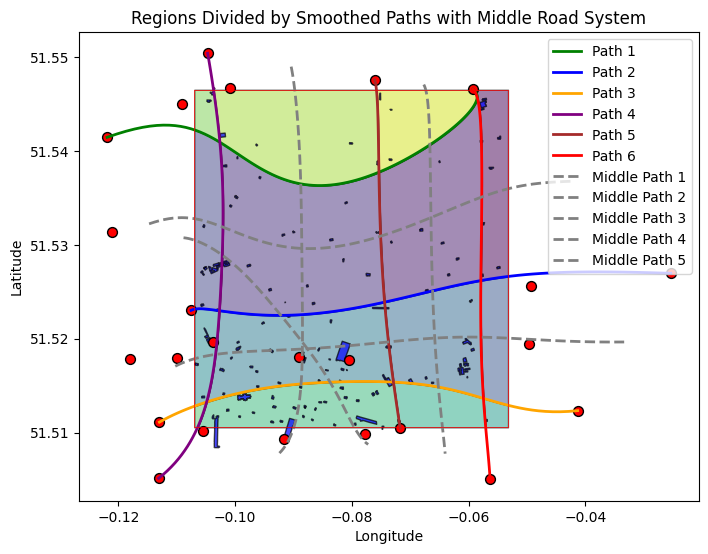

Smooth Paths List:
Path 1:
x: [-0.1219198  -0.12022774 -0.11866016 -0.11720471 -0.1158501  -0.11458598
 -0.11340291 -0.11229224 -0.11124609 -0.11025727 -0.10931922 -0.10842594
 -0.10757201 -0.10675246 -0.10596279 -0.10519893 -0.10445715 -0.10373412
 -0.1030268  -0.10233245 -0.10164861 -0.10097307 -0.10030385 -0.09963918
 -0.09897748 -0.09831735 -0.09765758 -0.09699708 -0.09633491 -0.09567027
 -0.09500247 -0.09433093 -0.09365517 -0.09297481 -0.09228955 -0.09159918
 -0.09090355 -0.09020259 -0.08949629 -0.0887847  -0.08806792 -0.08734612
 -0.08661948 -0.08588826 -0.08515276 -0.0844133  -0.08367025 -0.08292402
 -0.08217504 -0.0814238  -0.0806708  -0.07991657 -0.07916169 -0.07840677
 -0.07765242 -0.07689932 -0.07614816 -0.07539967 -0.07465459 -0.07391373
 -0.07317789 -0.07244794 -0.07172476 -0.07100926 -0.0703024  -0.06960516
 -0.06891855 -0.06824364 -0.06758149 -0.06693321 -0.06629996 -0.06568288
 -0.06508318 -0.06450206 -0.06394075 -0.06340049 -0.06288253 -0.06238812
 -0.0619185  -0.06147

In [33]:

# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Function to compute the midpoints between two curves
def compute_midpoints(curve1, curve2):
    # Ensure the two curves have the same number of points
    if len(curve1) != len(curve2):
        raise ValueError("Curves must have the same number of points")

    midpoints = (curve1 + curve2) / 2  # Midpoint between corresponding points
    return midpoints

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust figure size as needed

colors = ['green', 'blue', 'orange', 'purple', 'brown', 'red'] 
smooth_paths = []  # List to store smoothed paths
middle_paths = []  # List to store middle paths between neighboring curves

# Plot the connected paths with Bézier curves
for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)  # Use Bézier curve for smoothing
    
    # Store the smoothed path in the list
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color=color, linewidth=2, label=f'Path {i + 1}')

# Create a list to hold the LineString geometries of the smooth paths
line_strings = [LineString(curve) for curve in smooth_paths]

# Calculate and plot the middle paths between consecutive curves
for i in range(len(smooth_paths) - 1):
    curve1 = smooth_paths[i]
    curve2 = smooth_paths[i + 1]
    
    # Compute the midpoints between the two curves
    midpoints = compute_midpoints(curve1, curve2)
    
    # Create a Bézier curve for the new middle path
    middle_path = bezier_curve(midpoints)
    middle_paths.append(middle_path)

    # Plot the middle path
    ax.plot(middle_path[:, 0], middle_path[:, 1], color='gray', linestyle='--', linewidth=2, label=f'Middle Path {i + 1}')

# Create a list for split regions and perform splitting (same as before)
split_regions = [bounding_box]

# Split the bounding box by the smoothed paths
for line in line_strings:
    new_split_regions = []
    for region in split_regions:
        try:
            # Split the region by the smoothed path
            result = split(region, line)
            if result.geom_type == 'GeometryCollection':
                for geom in result.geoms:
                    if isinstance(geom, Polygon):
                        new_split_regions.append(geom)
            else:
                new_split_regions.extend(result.geoms)  # Use geoms directly
        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    split_regions = new_split_regions  # Update the list of regions

# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Plot the bounding box as a red line region
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]})
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=0.5)

# Assign a color to each region
num_regions = len(final_regions_gdf)
colors = cm.viridis(np.linspace(0, 1, num_regions))  # Use the viridis colormap

# Plot the resulting split regions with distinct colors
for i, region in enumerate(final_regions_gdf['geometry']):
    final_regions_gdf.iloc[[i]].plot(ax=ax, color=colors[i], alpha=0.5, edgecolor='black')

# Optional: Plot only the landmark nodes
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Highlight remaining points
for point in filtered_endpoints:
    ax.scatter(point[0], point[1], color='red', s=50, edgecolor='black')

# Set plot title and labels
plt.title("Regions Divided by Smoothed Paths with Middle Road System")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

# Show the plot
plt.show()

# Output the list of smooth and middle paths
print("Smooth Paths List:")
for idx, path in enumerate(smooth_paths):
    print(f'Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')

print("\nMiddle Paths List:")
for idx, path in enumerate(middle_paths):
    print(f'Middle Path {idx + 1}:')
    print(f'x: {path[:, 0]}, y: {path[:, 1]}')


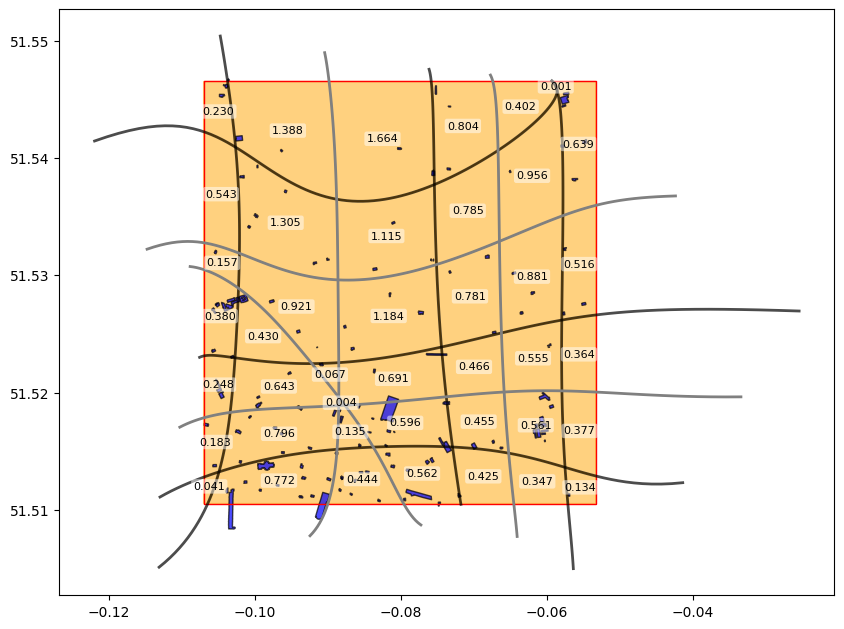

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString, Polygon, box
from shapely.ops import split
import geopandas as gpd
import matplotlib.cm as cm
from scipy.special import comb

# Set the random seed for consistency
retail_plots = [6, 17]

# Function to create Bézier curves
def bezier_curve(points, num_points=100):
    n = len(points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))

    for i in range(n + 1):
        binom = comb(n, i)
        curve += np.outer(binom * (t ** i) * ((1 - t) ** (n - i)), points[i])

    return curve

# Function to compute the midpoints between two curves
def compute_midpoints(curve1, curve2):
    # Ensure the two curves have the same number of points
    if len(curve1) != len(curve2):
        raise ValueError("Curves must have the same number of points")

    midpoints = (curve1 + curve2) / 2  # Midpoint between corresponding points
    return midpoints

# Assuming df_E01004736 contains 'Longitude' and 'Latitude' columns
# Get the bounds from df_E01004736
min_longitude = df_E01004736['Longitude'].min()
max_longitude = df_E01004736['Longitude'].max()
min_latitude = df_E01004736['Latitude'].min()
max_latitude = df_E01004736['Latitude'].max()

# Create a bounding box for the area of interest
bounding_box = box(min_longitude, min_latitude, max_longitude, max_latitude)

# Create a GeoDataFrame for the bounding box
bbox_gdf = gpd.GeoDataFrame({'geometry': [bounding_box]}, crs='EPSG:4326')

# Create a plot to visualize the connections
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed

# Plot the bounding box as a red line region
bbox_gdf.boundary.plot(ax=ax, color='red', linewidth=1, label='Bounding Box')

# Create a list to hold the smoothed paths and middle paths
smooth_paths = []
middle_paths = []

# Convert connected_paths to Bézier curves
for path in connected_paths:
    smooth_path = bezier_curve(path)  # Use Bézier curve for smoothing
    smooth_paths.append(smooth_path)
    if isinstance(smooth_path, np.ndarray):
        smooth_path_line = LineString(smooth_path)  # Convert to LineString
        x, y = smooth_path_line.xy
        ax.plot(x, y, color='black', linewidth=2, alpha=0.7)

# Compute and plot the middle paths between consecutive smoothed paths
for i in range(len(smooth_paths) - 1):
    curve1 = smooth_paths[i]
    curve2 = smooth_paths[i + 1]
    
    # Compute the midpoints between the two curves
    midpoints = compute_midpoints(curve1, curve2)
    
    # Create a Bézier curve for the new middle path
    middle_path = bezier_curve(midpoints)
    middle_paths.append(middle_path)

    # Plot the middle path
    ax.plot(middle_path[:, 0], middle_path[:, 1], color='gray', linewidth=2, label=f'Middle Path {i + 1}')

# Add the middle paths to the smooth paths for splitting
all_paths_for_splitting = smooth_paths + middle_paths

# Initialize a list for split regions
split_regions = [bounding_box]

# Set the area threshold (e.g., 0.03 km²)
area_threshold = 0

# Split the bounding box by both smoothed paths and middle paths
for curve in all_paths_for_splitting:
    line = LineString(curve)
    new_split_regions = []
    for region in split_regions:
        try:
            # Calculate the area of the region
            area_km2 = region.area * 111.32 * 111.32  # Convert area to km²

            # Only attempt to split with the middle path if the area is larger than the threshold
            if area_km2 < area_threshold :
                new_split_regions.append(region)  # Skip splitting for this region if it's too small

            else:
                # Split the region by the current path (smoothed or middle path)
                result = split(region, line)
                if result.geom_type == 'GeometryCollection':
                    for geom in result.geoms:
                        if isinstance(geom, Polygon) and geom.is_valid:
                            new_split_regions.append(geom)
                else:
                    new_split_regions.extend([geom for geom in result.geoms if isinstance(geom, Polygon) and geom.is_valid])

        except Exception as e:
            print(f"Error splitting region: {e}")
            new_split_regions.append(region)  # Keep the original region if splitting fails
    
    split_regions = new_split_regions  # Update the list of regions



# Create a GeoDataFrame for the final regions
final_regions_gdf = gpd.GeoDataFrame({'geometry': split_regions})

# Calculate areas and add them to the GeoDataFrame
final_regions_gdf['Area (km²)'] = final_regions_gdf.geometry.area * 111.32 * 111.32  # Calculate the area in km²

# Create lists for the functions, colors, and plot names
functions = []
colors = []
plot_names = []  # List to hold plot names

for i, region in final_regions_gdf.iterrows():
    # Determine the function based on area and specific plot indices
    area_km2 = region.geometry.area * 111.32 * 111.32  # Calculate the area in km²
    if area_km2 > 0:
        functions.append('Residential')
        colors.append('orange')  # Color for roads
    # Assign plot names based on indices
    plot_names.append(f'Plot {i + 1}')  # Plot names like 'Plot 1', 'Plot 2', etc.

# Add the functions, colors, and plot names to the GeoDataFrame
final_regions_gdf['Function'] = functions
final_regions_gdf['Color'] = colors
final_regions_gdf['Plot Name'] = plot_names

# Plot each region with its corresponding color
for i, region in final_regions_gdf.iterrows():
    # Plot the region
    ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.5, edgecolor='black'))

    # Calculate the centroid for labeling
    centroid = region.geometry.centroid
    ax.text(centroid.x, centroid.y,f'{region["Area (km²)"]:.3f}', 
            ha='center', va='center', fontsize=8, color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# Optionally plot landmark buildings if they exist in df_building
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

# Create a DataFrame with geometry, function, plot name, and area
data = {
    'Geometry': final_regions_gdf['geometry'],
    'Function': final_regions_gdf['Function'],
    'Plot Name': final_regions_gdf['Plot Name'],
    'Area (km²)': final_regions_gdf['Area (km²)']
}
regions_df = pd.DataFrame(data)

# Display the DataFrame



Region 0: 8 vertices
Region 1: 5 vertices
Region 2: 5 vertices
Region 3: 5 vertices
Region 4: 6 vertices
Region 5: 10 vertices
Region 6: 8 vertices
Region 7: 9 vertices
Region 8: 6 vertices
Region 9: 10 vertices
Region 10: 10 vertices
Region 11: 7 vertices
Region 12: 6 vertices
Region 13: 6 vertices
Region 14: 5 vertices
Region 15: 5 vertices
Region 16: 5 vertices
Region 17: 5 vertices
Region 18: 5 vertices
Region 19: 5 vertices
Region 20: 5 vertices
Region 21: 5 vertices
Region 22: 7 vertices
Region 23: 7 vertices
Region 24: 5 vertices
Region 25: 5 vertices
Region 26: 7 vertices
Region 27: 6 vertices
Region 28: 6 vertices
Region 29: 5 vertices
Region 30: 5 vertices
Region 31: 5 vertices
Region 32: 5 vertices
Region 33: 6 vertices
Region 34: 7 vertices
Region 35: 5 vertices
Region 36: 5 vertices
Region 37: 8 vertices
Region 38: 10 vertices
Region 39: 8 vertices
Region 40: 9 vertices
Region 41: 4 vertices


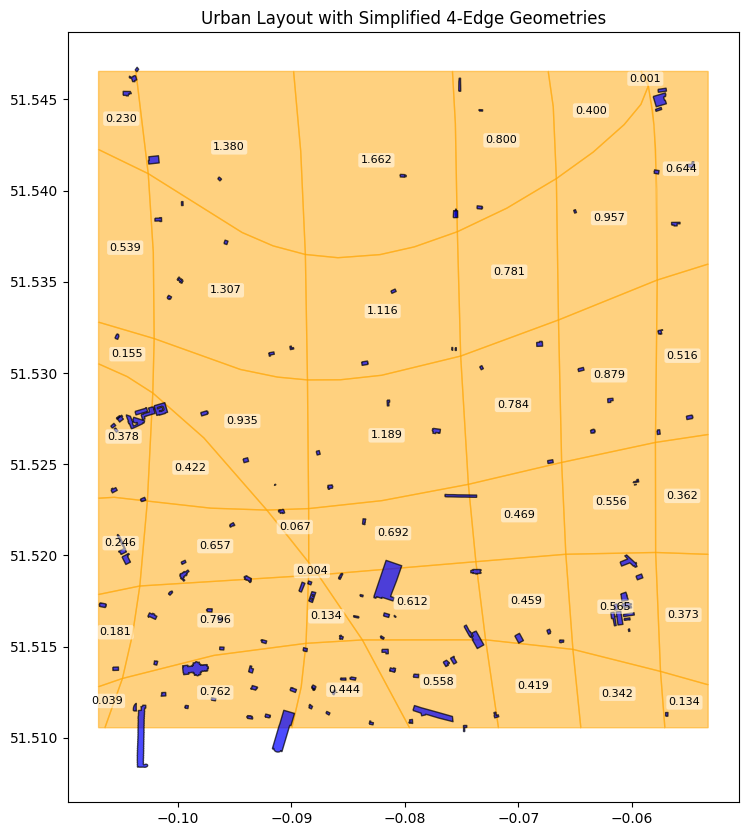

,geometry,Area (km²),Function,Color
0,"POLYGON ((-0.05918 51.54653, -0.05327 51.54653...",0.643708,others,orange
1,"POLYGON ((-0.05327 51.53597, -0.05327 51.52663...",0.515841,others,orange
2,"POLYGON ((-0.05791 51.52619, -0.06618 51.52509...",0.879484,others,orange
3,"POLYGON ((-0.06618 51.52509, -0.0744 51.52389,...",0.783533,others,orange
4,"POLYGON ((-0.07507 51.53093, -0.07537 51.53774...",0.780983,others,orange


In [35]:
from shapely.geometry import Polygon

# Function to simplify and convert to 4-edge geometries (with an iterative approach)
def simplify_to_quad_iteratively(geometry, tolerance=0.01, max_iterations=10):
    # Ensure that the geometry is a Polygon (not MultiPolygon)
    if isinstance(geometry, Polygon):
        current_geometry = geometry
        iteration = 0
        
        # Continue simplifying until the geometry has exactly 4 vertices or max iterations
        while len(current_geometry.exterior.coords) > 4 and iteration < max_iterations:
            current_geometry = current_geometry.simplify(tolerance, preserve_topology=True)
            iteration += 1
        
        return current_geometry
    else:
        # Handle cases where the geometry is a MultiPolygon or other geometry types
        return geometry  # You can choose to handle these cases differently

def apply_simplification(final_regions_gdf):
    simplified_regions = []
    
    for i, region in final_regions_gdf.iterrows():
        # Simplify the geometry and keep only 4-edge polygons iteratively
        simplified_geometry = simplify_to_quad_iteratively(region.geometry, tolerance=0.0001)
        
        # Add the simplified geometry to the list
        simplified_regions.append({
            'geometry': simplified_geometry,
            'Area (km²)': simplified_geometry.area * 111.32 * 111.32  # Calculate area in km²
        })
    
    # Create a new GeoDataFrame with the simplified geometries
    simplified_gdf = gpd.GeoDataFrame(simplified_regions)
    simplified_gdf['Function'] = 'others'  # Assuming residential function for all
    simplified_gdf['Color'] = 'orange'  # Color for residential areas
    
    return simplified_gdf

# Apply the iterative simplification
final_regions_simplified_gdf = apply_simplification(final_regions_gdf)

# Print the number of vertices for each geometry
for i, region in final_regions_simplified_gdf.iterrows():
    num_vertices = len(region.geometry.exterior.coords)  # Number of vertices of the polygon
    print(f"Region {i}: {num_vertices} vertices")

# Plot the simplified geometries
fig, ax = plt.subplots(figsize=(10, 10))

for i, region in final_regions_simplified_gdf.iterrows():
    ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.5, edgecolor='black'))
    centroid = region.geometry.centroid
    ax.text(centroid.x, centroid.y, f'{region["Area (km²)"]:.3f}', ha='center', va='center', fontsize=8, color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# Optionally, plot landmark buildings if they exist
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")

plt.title("Urban Layout with Simplified 4-Edge Geometries")
plt.show()

final_regions_simplified_gdf.head()


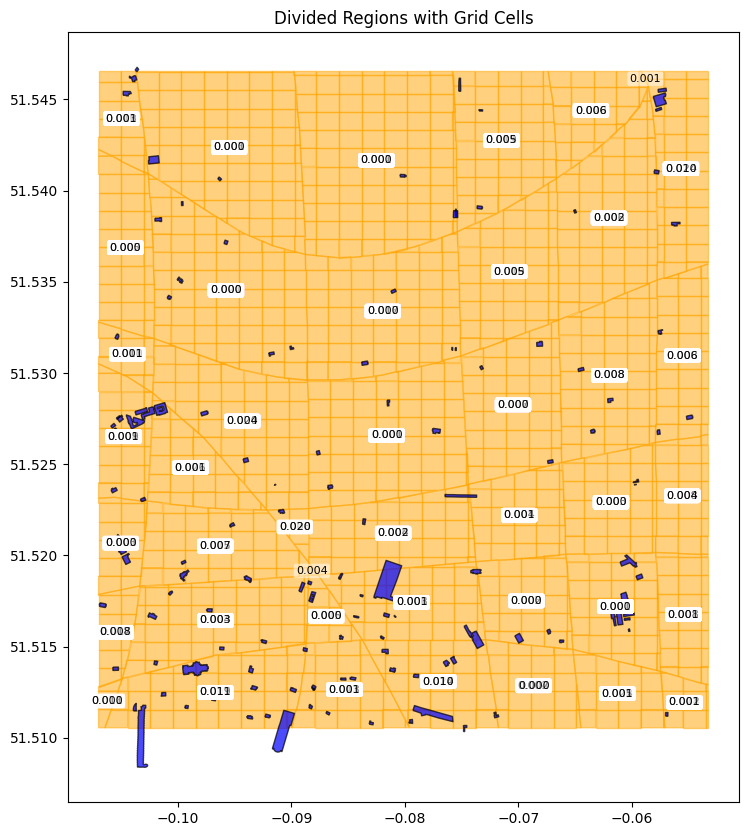

,geometry,Function,Color,Area (km²),Original Polygon Centroid
0,"POLYGON ((-0.05776 51.53509, -0.05776 51.53609...",others,orange,0.006767,POINT (-0.0556656544486325 51.54119810841534)
1,"POLYGON ((-0.05777 51.53709, -0.05718 51.53709...",others,orange,0.007254,POINT (-0.0556656544486325 51.54119810841534)
2,"POLYGON ((-0.05778 51.53809, -0.05718 51.53809...",others,orange,0.007342,POINT (-0.0556656544486325 51.54119810841534)
3,"POLYGON ((-0.05778 51.53909, -0.05718 51.53909...",others,orange,0.007430,POINT (-0.0556656544486325 51.54119810841534)
4,"POLYGON ((-0.05779 51.54003, -0.05779 51.54009...",others,orange,0.007520,POINT (-0.0556656544486325 51.54119810841534)
...,...,...,...,...,...
1321,"POLYGON ((-0.05936 51.54653, -0.05936 51.54565...",others,orange,0.021656,POINT (-0.0635945879876951 51.544386510280596)
1322,"POLYGON ((-0.05936 51.5446, -0.05936 51.54465,...",others,orange,0.000027,POINT (-0.0635945879876951 51.544386510280596)
1323,"POLYGON ((-0.05919 51.54472, -0.05928 51.54465...",others,orange,0.005513,POINT (-0.0635945879876951 51.544386510280596)
1324,"POLYGON ((-0.05919 51.54653, -0.05855 51.54572...",others,orange,0.005584,POINT (-0.0635945879876951 51.544386510280596)


In [36]:
import geopandas as gpd
from shapely.geometry import Polygon, box
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the grid size and create rectangular grid cells for each polygon
def generate_grid_for_polygon(polygon, grid_width=1, grid_height=0.5):
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    grid_cells = []

    # Create grid cells using bounding box (in km, assuming CRS is in meters or lat-lon)
    x_coords = np.arange(minx, maxx, grid_width)
    y_coords = np.arange(miny, maxy, grid_height)

    for x in x_coords:
        for y in y_coords:
            # Create a rectangular grid cell
            grid_cell = box(x, y, x + grid_width, y + grid_height)

            # Check if the grid cell intersects with the polygon
            intersection = polygon.intersection(grid_cell)
            if intersection.is_valid and intersection.area > 0:
                grid_cells.append(intersection)
    
    return grid_cells

# Step 2: Apply the grid division to each polygon
def apply_grid_to_polygons(final_regions_gdf, grid_width, grid_height):
    divided_regions = []

    for _, region in final_regions_gdf.iterrows():
        polygon = region.geometry
        # Generate grid cells for the polygon
        grid_cells = generate_grid_for_polygon(polygon, grid_width, grid_height)

        # For each grid cell that intersects with the polygon, add it to the list
        for grid_cell in grid_cells:
            divided_regions.append({
                'geometry': grid_cell,
                'Function': region['Function'],
                'Color': region['Color'],
                'Area (km²)': grid_cell.area * 111.32 * 111.32,  # Convert area to km²
                'Original Polygon Centroid': polygon.centroid
            })
    
    # Create a new GeoDataFrame for the divided regions
    divided_regions_gdf = gpd.GeoDataFrame(divided_regions)

    return divided_regions_gdf

# Apply the grid division to each polygon
divided_regions_gdf = apply_grid_to_polygons(final_regions_simplified_gdf, grid_width=0.002, grid_height=0.001)

# Step 3: Plot the divided regions
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the divided regions
for _, region in divided_regions_gdf.iterrows():
    ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=region.Color, alpha=0.5, edgecolor='black'))

    # Plot the centroid
    centroid = region['Original Polygon Centroid']
    ax.text(centroid.x, centroid.y, f'{region["Area (km²)"]:.3f}', ha='center', va='center', fontsize=8, color='black', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings")
plt.title("Divided Regions with Grid Cells")
plt.show()

# Optionally, inspect the first few rows of the divided regions GeoDataFrame
divided_regions_gdf


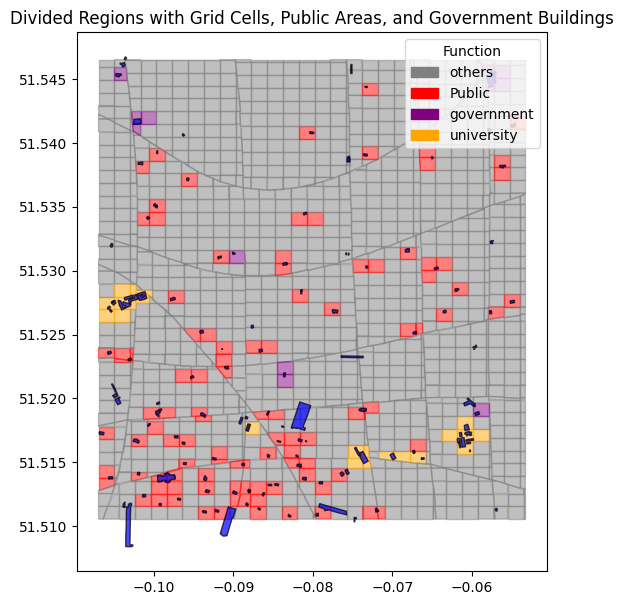

,geometry,Function,Color,Area (km²),Original Polygon Centroid
0,"POLYGON ((-0.05776 51.53509, -0.05776 51.53609...",others,orange,0.006767,POINT (-0.0556656544486325 51.54119810841534)
1,"POLYGON ((-0.05777 51.53709, -0.05718 51.53709...",others,orange,0.007254,POINT (-0.0556656544486325 51.54119810841534)
2,"POLYGON ((-0.05778 51.53809, -0.05718 51.53809...",others,orange,0.007342,POINT (-0.0556656544486325 51.54119810841534)
3,"POLYGON ((-0.05778 51.53909, -0.05718 51.53909...",others,orange,0.007430,POINT (-0.0556656544486325 51.54119810841534)
4,"POLYGON ((-0.05779 51.54003, -0.05779 51.54009...",others,orange,0.007520,POINT (-0.0556656544486325 51.54119810841534)
...,...,...,...,...,...
1321,"POLYGON ((-0.05936 51.54653, -0.05936 51.54565...",others,orange,0.021656,POINT (-0.0635945879876951 51.544386510280596)
1322,"POLYGON ((-0.05936 51.5446, -0.05936 51.54465,...",others,orange,0.000027,POINT (-0.0635945879876951 51.544386510280596)
1323,"POLYGON ((-0.05919 51.54472, -0.05928 51.54465...",others,orange,0.005513,POINT (-0.0635945879876951 51.544386510280596)
1324,"POLYGON ((-0.05919 51.54653, -0.05855 51.54572...",others,orange,0.005584,POINT (-0.0635945879876951 51.544386510280596)


In [39]:
# Step 3: Check for intersections with building nodes and update the "Function"
def update_function_for_areas(divided_regions_gdf, building_df):
    # Remove train stations from the building dataframe
    building_df = building_df[building_df['type'] != 'train_station']
    
    for idx, region in divided_regions_gdf.iterrows():
        region_geometry = region['geometry']
        for _, building in building_df.iterrows():
            building_point = building.geometry
            if region_geometry.intersects(building_point):
                if building['type'] == 'government':
                    divided_regions_gdf.at[idx, 'Function'] = 'government'
                elif building['type'] == 'university':
                    divided_regions_gdf.at[idx, 'Function'] = 'university'
                else:
                    divided_regions_gdf.at[idx, 'Function'] = 'Public'
                break  # No need to check other buildings once we find an intersection
    return divided_regions_gdf

# Update function for areas with buildings
divided_regions_gdf = update_function_for_areas(divided_regions_gdf, df_building)

# Step 4: Plot the divided regions with a legend for different functions
fig, ax = plt.subplots(figsize=(7, 7))

# Create a color map based on the "Function" column
color_map = {
    'others': 'grey',
    'Public': 'red',
    'government': 'purple',
    'university': 'orange',
    # Add other functions as needed
}

# Plot the divided regions with different colors based on function
for _, region in divided_regions_gdf.iterrows():
    function = region['Function']
    color = color_map.get(function, 'gray')  # Default to gray if function is not in the map
    ax.add_patch(plt.Polygon(np.array(region.geometry.exterior.coords), color=color, alpha=0.5, edgecolor='black'))

    # Plot the centroid
    centroid = region['Original Polygon Centroid']
   #  ax.text(centroid.x, centroid.y, f'{region["Area (km²)"]:.3f}', ha='center', va='center', fontsize=8, color='black', 
   #          bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

# Plot landmark buildings as blue points
df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings", markersize=20)

# Create a custom legend based on the color map
from matplotlib.patches import Patch
legend_labels = [Patch(color=color, label=label) for label, color in color_map.items()]
ax.legend(handles=legend_labels, title="Function", loc="upper right")

# Set the title and show the plot
plt.title("Divided Regions with Grid Cells, Public Areas, and Government Buildings")
plt.show()

# Optionally, inspect the first few rows of the updated GeoDataFrame
divided_regions_gdf


In [40]:
df_building = df_building[df_building['type'] != 'train_station']

Generation 0: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 1: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 2: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 3: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 4: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 5: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 6: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 7: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 8: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 9: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 10: Best fitness = 14935.07676250145, Mutation rate = 0.100
Generation 11: Best fitness = 14935.07676250145, Mutation rate = 0.105
Generation 12: Best fitness = 14935.07676250145, Mutation rate = 0.110
Generation 13: Best fitness = 14935.07676250145, Mutation rate = 0.116
Generation 14: B

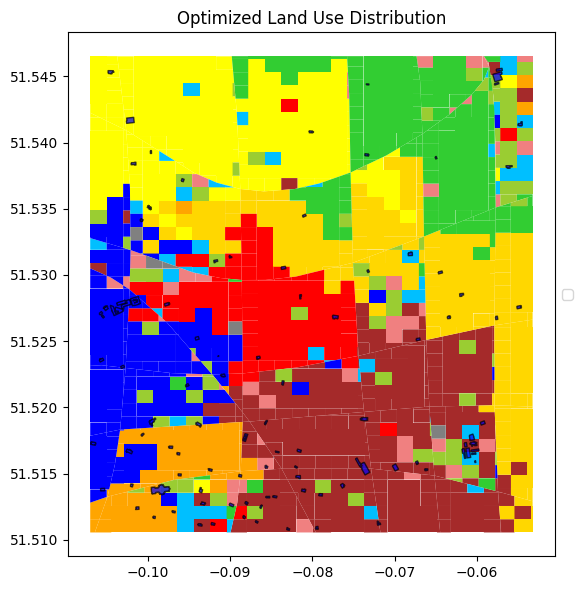


Land Use Distribution:
high density residential: 275 regions (20.74%)
Low density residential: 203 regions (15.31%)
medium density residential: 198 regions (14.93%)
Public Open space: 168 regions (12.67%)
office: 141 regions (10.63%)
Regional commercial: 98 regions (7.39%)
Semi-public open space: 72 regions (5.43%)
Mixed use: 72 regions (5.43%)
Neighborhood service: 48 regions (3.62%)
Neighborhood commercial: 45 regions (3.39%)
industrial: 6 regions (0.45%)

Total number of regions: 1326
Best fitness score: 14935.07676250145


In [95]:

random.seed = 1
np.random.seed(1)

land_use_types = {
    'high density residential': {'percentage': 0.20, 'color': 'brown', 'deprivation': 'E/H/T/C', 'priority': 7},
    'medium density residential': {'percentage': 0.15, 'color': 'gold', 'deprivation': 'E/H/T/C', 'priority': 7},
    'Low density residential': {'percentage': 0.15, 'color': 'yellow', 'deprivation': 'E/H/T/C', 'priority': 7},
    'Neighborhood commercial': {'percentage': 0.03, 'color': 'lightcoral', 'deprivation': 'E/H/C', 'priority': 2},
    'Neighborhood service': {'percentage': 0.03, 'color': 'deepskyblue', 'deprivation': 'E/C', 'priority': 2},
    'Regional commercial': {'percentage': 0.07, 'color': 'red', 'deprivation': 'E/H/C', 'priority': 1},
    'Mixed use': {'percentage': 0.05, 'color': 'orange', 'deprivation': 'E/H/C', 'priority': 1},
    'office': {'percentage': 0.10, 'color': 'blue', 'deprivation': 'E/C', 'priority': 3},
    'industrial': {'percentage': 0.05, 'color': 'grey', 'deprivation': 'E/C', 'priority': 6},
    'Public Open space': {'percentage': 0.12, 'color': 'limegreen', 'deprivation': 'H', 'priority': 5},
    'Semi-public open space': {'percentage': 0.05, 'color': 'yellowgreen', 'deprivation': 'H', 'priority': 5}
}

# Precompute neighbors for all regions
def precompute_neighbors(divided_regions_gdf):
    neighbors_dict = {}
    for idx, region in divided_regions_gdf.iterrows():
        neighbors = divided_regions_gdf[divided_regions_gdf.geometry.touches(region.geometry)].index.tolist()
        neighbors_dict[idx] = neighbors
    return neighbors_dict

neighbors_dict = precompute_neighbors(divided_regions_gdf)

# Priority weights for each land use type
priority_weights = {land_use: info['priority'] for land_use, info in land_use_types.items()}

# Deprivation weights based on land use type and deprivation code
deprivation_weights = {
    'E': {land_use: 1.5 if 'E' in info['deprivation'] else 1.0 for land_use, info in land_use_types.items()},
    'H': {land_use: 1.5 if 'H' in info['deprivation'] else 1.0 for land_use, info in land_use_types.items()},
    'T': {land_use: 1.5 if 'T' in info['deprivation'] else 1.0 for land_use, info in land_use_types.items()},
    'C': {land_use: 1.5 if 'C' in info['deprivation'] else 1.0 for land_use, info in land_use_types.items()}
}

# Enhanced fitness function with additional criteria
def fitness_function(assignment):
    cluster_score = sum(sum(1 for n in neighbors_dict[idx] if assignment.get(n) == land_use) for idx, land_use in assignment.items())
    
    # Add diversity penalty
    land_use_counts = {lu: sum(1 for v in assignment.values() if v == lu) for lu in land_use_types}
    diversity_penalty = sum((count / len(assignment) - land_use_types[lu]['percentage'])**2 for lu, count in land_use_counts.items())
    
    # Add connectivity bonus
    connectivity_bonus = sum(len(set(assignment[n] for n in neighbors_dict[idx])) for idx in assignment)
    
    # Add penalty for industrial and office near residential
    residential_types = ['high density residential', 'medium density residential', 'Low density residential']
    work_types = ['industrial']
    proximity_penalty = sum(
        1 for idx, land_use in assignment.items()
        if land_use in work_types
        and any(assignment.get(n) in residential_types for n in neighbors_dict[idx])
    )
    
    # Add bonus for semi-public open space and neighborhood commercial scattered in residential zones
    scattered_bonus = sum(
        1 for idx, land_use in assignment.items()
        if land_use in ['Semi-public open space', 'Neighborhood commercial', 'Neighborhood service']
        and any(assignment.get(n) in residential_types for n in neighbors_dict[idx])
    )
    
    # Add bonus for clustered Public Open space
    public_open_space_cluster_bonus = sum(
        1 for idx, land_use in assignment.items()
        if land_use == 'Public Open space'
        and any(assignment.get(n) == 'Public Open space' for n in neighbors_dict[idx])
    )
    
    # Add priority and deprivation weights
    priority_score = sum(priority_weights[land_use] for land_use in assignment.values())
    deprivation_score = sum(deprivation_weights[get_deprivation_code(idx)][land_use] for idx, land_use in assignment.items())
    
    # Calculate fitness score with increased priority for priority_score and deprivation_score
    fitness_score = (
        cluster_score 
        - 10 * diversity_penalty 
        + 0.1 * connectivity_bonus 
        - 5 * proximity_penalty 
        + 0 * scattered_bonus
        + 1 * public_open_space_cluster_bonus
        + 1 * priority_score  # Increased weight for priority_score
        + 1 * deprivation_score  # Increased weight for deprivation_score
    )

    return fitness_score

# Helper function to get deprivation code (replace with actual logic)
def get_deprivation_code(idx):
    # This is a placeholder. Replace with actual logic to determine deprivation code for each region
    return random.choice(['E', 'H', 'T', 'C'])

# Initialize population with improved clustering and diversity
def initialize_population(population_size, land_use_types, divided_regions_gdf):
    population = []
    region_indices = list(divided_regions_gdf.index)
    num_regions = len(region_indices)
    
    for _ in range(population_size):
        individual = {}
        remaining_regions = set(region_indices)
        land_use_list = list(land_use_types.keys())
        random.shuffle(land_use_list)  # Shuffle land use types for each individual
        
        for land_use in land_use_list:
            num_regions_for_type = max(1, int(land_use_types[land_use]['percentage'] * num_regions))
            
            if remaining_regions:
                start_region = random.choice(list(remaining_regions))
                individual[start_region] = land_use
                remaining_regions.remove(start_region)
                assigned_regions = 1
                
                if land_use == 'Public Open space':
                    # Cluster Public Open space
                    frontier = set(neighbors_dict[start_region])
                    while assigned_regions < num_regions_for_type and frontier:
                        next_region = random.choice(list(frontier & remaining_regions)) if frontier & remaining_regions else None
                        if next_region is None:
                            break
                        individual[next_region] = land_use
                        remaining_regions.remove(next_region)
                        frontier.update(neighbors_dict[next_region])
                        assigned_regions += 1
                elif land_use in ['Semi-public open space', 'Neighborhood commercial', 'Neighborhood service']:
                    # Scatter Semi-public open space and Neighborhood commercial
                    while assigned_regions < num_regions_for_type and remaining_regions:
                        next_region = random.choice(list(remaining_regions))
                        individual[next_region] = land_use
                        remaining_regions.remove(next_region)
                        assigned_regions += 1
                else:
                    # For other land uses, use the original clustering approach
                    frontier = set(neighbors_dict[start_region])
                    while assigned_regions < num_regions_for_type and frontier:
                        next_region = random.choice(list(frontier & remaining_regions)) if frontier & remaining_regions else None
                        if next_region is None:
                            break
                        individual[next_region] = land_use
                        remaining_regions.remove(next_region)
                        frontier.update(neighbors_dict[next_region])
                        assigned_regions += 1

        # After assigning most regions, handle unassigned regions
        for region in remaining_regions:
            individual[region] = random.choice(land_use_list)  # Randomly assign remaining regions

        population.append(individual)
    
    return population

# Improved Genetic Algorithm with adaptive mutation rate
def genetic_algorithm(num_generations, population_size, land_use_types, divided_regions_gdf):
    population = initialize_population(population_size, land_use_types, divided_regions_gdf)
    best_individual = None
    best_fitness = -np.inf
    generations_without_improvement = 0
    mutation_rate = 0.1

    for generation in range(num_generations):
        # Evaluate fitness
        fitness_scores = [fitness_function(individual) for individual in population]

        # Track the best individual and fitness in the current generation
        generation_best_fitness = max(fitness_scores)
        generation_best_individual = population[fitness_scores.index(generation_best_fitness)]

        # Selection using tournament selection
        selected = []
        for _ in range(population_size):
            tournament = random.sample(list(zip(population, fitness_scores)), 5)
            selected.append(max(tournament, key=lambda x: x[1])[0])

        # Crossover and Mutation
        new_population = []
        for i in range(0, population_size, 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutation(child1, land_use_types, mutation_rate)
            child2 = mutation(child2, land_use_types, mutation_rate)
            new_population.extend([child1, child2])

        population = new_population

        # Track best individual overall
        if generation_best_fitness > best_fitness:
            best_fitness = generation_best_fitness
            best_individual = generation_best_individual
            generations_without_improvement = 0
        else:
            generations_without_improvement += 1

        # Adaptive mutation rate
        if generations_without_improvement > 10:
            mutation_rate = min(0.5, mutation_rate * 1.05)
        else:
            mutation_rate = max(0.1, mutation_rate * 0.95)

        # Print fitness score and mutation rate for the generation
        print(f"Generation {generation}: Best fitness = {best_fitness}, Mutation rate = {mutation_rate:.3f}")

        # Early stopping
        if generations_without_improvement > 50:
            print("Early stopping due to lack of improvement")
            break

    return best_individual, best_fitness


# Improved crossover with uniform crossover
def crossover(parent1, parent2):
    child1, child2 = {}, {}
    for key in parent1.keys():
        if random.random() < 0.5:
            child1[key], child2[key] = parent1[key], parent2[key]
        else:
            child1[key], child2[key] = parent2[key], parent1[key]
    return child1, child2

# Improved mutation with adaptive rate
def mutation(individual, land_use_types, mutation_rate):
    for idx in individual:
        if random.random() < mutation_rate:
            individual[idx] = random.choice(list(land_use_types.keys()))
    return individual

# Run the improved genetic algorithm
best_assignment, best_fitness = genetic_algorithm(num_generations=200, population_size=100, land_use_types=land_use_types, divided_regions_gdf=divided_regions_gdf)

# Update the 'Function' column in divided_regions_gdf based on GA output
divided_regions_gdf['Function'] = divided_regions_gdf.index.map(lambda x: best_assignment.get(x, 'Unassigned'))

# Plot the final land function assignment
fig, ax = plt.subplots(figsize=(6, 6))

for land_use, info in land_use_types.items():
    mask = divided_regions_gdf['Function'] == land_use
    divided_regions_gdf[mask].plot(ax=ax, color=info['color'], label=land_use)

df_building.plot(ax=ax, color='blue', edgecolor='black', alpha=0.7, label="Landmark Buildings", markersize=20)
# Set the title and legend
ax.set_title("Optimized Land Use Distribution")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()

# Print statistics
function_counts = divided_regions_gdf['Function'].value_counts()
total_regions = len(divided_regions_gdf)

print("\nLand Use Distribution:")
for function, count in function_counts.items():
    percentage = (count / total_regions) * 100
    print(f"{function}: {count} regions ({percentage:.2f}%)")

print(f"\nTotal number of regions: {total_regions}")
print(f"Best fitness score: {best_fitness}")


In [96]:
# Copy the divided_regions_gdf
divided_regions_gdf_updated = divided_regions_gdf.copy()

# Update function for public areas
def update_function_for_public_areas(gdf, building_df):
    for idx, region in gdf.iterrows():
        region_geometry = region['geometry']
        for _, building in building_df.iterrows():
            building_point = building.geometry
            if region_geometry.contains(building_point):
                if building['type'] == 'government':
                    gdf.at[idx, 'Function'] = 'government'
                elif building['type'] == 'university':
                    gdf.at[idx, 'Function'] = 'university'
                else:  # Assuming 'church' represents public buildings
                    gdf.at[idx, 'Function'] = 'Public'
                break  # Stop checking other buildings once we find a match
    return gdf

# Apply the function to update divided_regions_gdf_updated
divided_regions_gdf_updated = update_function_for_public_areas(divided_regions_gdf_updated, df_building)

# Print the number of changes made
changes = (divided_regions_gdf_updated['Function'] != divided_regions_gdf['Function']).sum()
print(f"Number of regions updated: {changes}")

# If you want to use the updated dataframe for further processing, 
# you can assign it back to divided_regions_gdf
# divided_regions_gdf = divided_regions_gdf_updated


Number of regions updated: 53


In [55]:
divided_regions_gdf_updated.Function.unique()

array(['high density residential', 'Semi-public open space',
       'Neighborhood service', 'industrial', 'government',
       'Regional commercial', 'Low density residential', 'office',
       'Mixed use', 'Neighborhood commercial', 'Public',
       'Public Open space', 'medium density residential', 'university'],
      dtype=object)

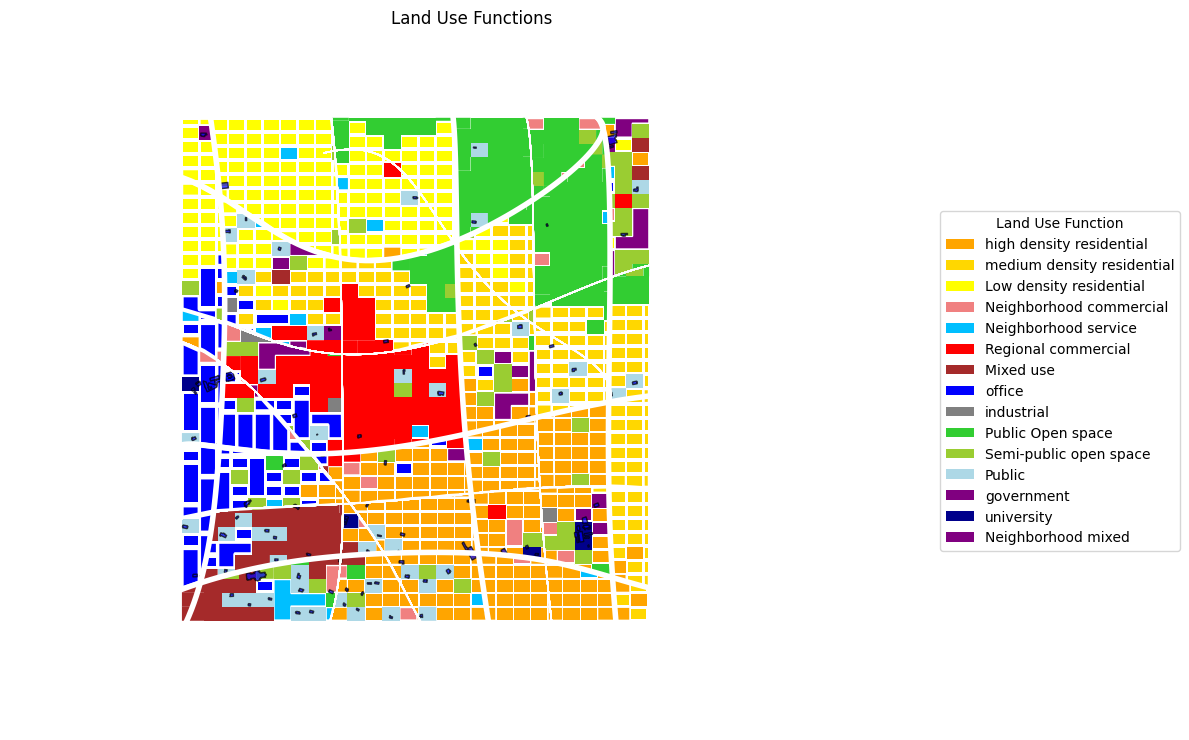

In [107]:

fig, ax = plt.subplots(figsize=(12,12))

color_map = {
   'high density residential': 'orange',
   'medium density residential': 'gold',
   'Low density residential': 'yellow',
   'Neighborhood commercial': 'lightcoral',
   'Neighborhood service': 'deepskyblue',
   'Regional commercial': 'red',
   'Mixed use': 'brown',
   'office': 'blue',
   'industrial': 'grey',
   'Public Open space': 'limegreen',
   'Semi-public open space': 'yellowgreen',
   'Public': 'lightblue',
   'government': 'purple',
   'university': 'darkblue',
}

for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)  # Use Bézier curve for smoothing
    
    # Store the smoothed path in the list
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color='white', linewidth=4, label=f'Path {i + 1}')

# Create a list to hold the LineString geometries of the smooth paths
line_strings = [LineString(curve) for curve in smooth_paths]

# Calculate and plot the middle paths between consecutive curves
for i in range(len(smooth_paths) - 1):
    curve1 = smooth_paths[i]
    curve2 = smooth_paths[i + 1]
    
    # Compute the midpoints between the two curves
    midpoints = compute_midpoints(curve1, curve2)
    
    # Create a Bézier curve for the new middle path
    middle_path = bezier_curve(midpoints)
    middle_paths.append(middle_path)

    # Plot the middle path
    ax.plot(middle_path[:, 0], middle_path[:, 1], color='white', linewidth=1, label=f'Middle Path {i + 1}')

# Combine neighboring Neighborhood commercial and Neighborhood service regions
neighborhood_regions = divided_regions_gdf_updated[
    (divided_regions_gdf_updated['Function'] == 'Neighborhood commercial') |
    (divided_regions_gdf_updated['Function'] == 'Neighborhood service')
]
combined_neighborhood_regions = []
processed_indices = set()

for idx, region in neighborhood_regions.iterrows():
    if idx in processed_indices:
        continue
    combined_region = region.geometry
    function = region['Function']
    for other_idx, other_region in neighborhood_regions.iterrows():
        if idx != other_idx and other_idx not in processed_indices:
            if combined_region.touches(other_region.geometry) or combined_region.intersects(other_region.geometry):
                combined_region = combined_region.union(other_region.geometry)
                function = 'Neighborhood mixed' if function != other_region['Function'] else function
                processed_indices.add(other_idx)
    combined_neighborhood_regions.append((combined_region, function))
    processed_indices.add(idx)

# Plot the divided regions with different colors based on function
office_regions = []
for idx, region in divided_regions_gdf_updated.iterrows():
    if region['Function'] not in ['Neighborhood commercial', 'Neighborhood service']:
        color = color_map.get(region['Function'], 'lightgrey')  # Default to lightgrey if function is not in the map
        geometry = region.geometry
        if region['Function'] == 'high density residential':
            geometry = geometry.buffer(-0.00008)
        elif region['Function'] == 'medium density residential':
            geometry = geometry.buffer(-0.00015)
        elif region['Function'] == 'Low density residential':
            geometry = geometry.buffer(-0.00015)
        elif region['Function'] == 'office':
            office_regions.append(geometry)
            continue  # Skip plotting individual office regions
        if isinstance(geometry, MultiPolygon):
            for poly in geometry.geoms:
                ax.add_patch(plt.Polygon(poly.exterior.coords, facecolor=color, edgecolor='black', linewidth=0))
        else:
            ax.add_patch(plt.Polygon(geometry.exterior.coords, facecolor=color, edgecolor='black', linewidth=0))

# Plot combined neighborhood regions
for geometry, function in combined_neighborhood_regions:
    color = color_map.get(function, 'purple')  # Use purple for 'Neighborhood mixed'
    geometry = geometry.buffer(-0.0001)
    if isinstance(geometry, MultiPolygon):
        for poly in geometry.geoms:
            ax.add_patch(plt.Polygon(poly.exterior.coords, facecolor=color, edgecolor='black', linewidth=0))
    else:
        ax.add_patch(plt.Polygon(geometry.exterior.coords, facecolor=color, edgecolor='black', linewidth=0))

# Combine neighboring office regions (three at a time)
combined_office_regions = []
i = 0
while i < len(office_regions):
    if i + 2 < len(office_regions):
        # Check if the three regions are neighbors
        if (office_regions[i].touches(office_regions[i+1]) or office_regions[i].intersects(office_regions[i+1])) and \
           (office_regions[i+1].touches(office_regions[i+2]) or office_regions[i+1].intersects(office_regions[i+2])):
            combined = office_regions[i].union(office_regions[i+1]).union(office_regions[i+2])
            combined_office_regions.append(combined)
            i += 3
        else:
            combined_office_regions.append(office_regions[i])
            i += 1
    else:
        # Add remaining regions (less than three) individually
        while i < len(office_regions):
            combined_office_regions.append(office_regions[i])
            i += 1

# Plot the combined office regions with offset
for office in combined_office_regions:
    office = office.buffer(-0.0002)  # Offset inwards
    if isinstance(office, MultiPolygon):
        for poly in office.geoms:
            ax.add_patch(plt.Polygon(poly.exterior.coords, facecolor='blue', edgecolor='black', linewidth=0))
    else:
        ax.add_patch(plt.Polygon(office.exterior.coords, facecolor='blue', edgecolor='black', linewidth=0))

df_building.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, alpha=0.7, label="Landmark Buildings", markersize=20)

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='none', label=function)
                  for function, color in color_map.items()]
legend_elements.append(plt.Rectangle((0, 0), 1, 1, facecolor='purple', edgecolor='none', label='Neighborhood mixed'))
ax.legend(handles=legend_elements, title='Land Use Function', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Land Use Functions')
ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:

fig, ax = plt.subplots(figsize=(10,10))

color_map = {
   'high density residential': 'orange',
   'medium density residential': 'gold',
   'Low density residential': 'khaki',
   'Neighborhood commercial': 'lightcoral',
   'Neighborhood service': 'deepskyblue',
   'Regional commercial': 'red',
   'Mixed use': 'brown',
   'office': 'blue',
   'industrial': 'grey',
   'Public Open space': 'limegreen',
   'Semi-public open space': 'yellowgreen',
   'Public': 'lightblue',
   'government': 'purple',
   'university': 'darkblue',
}

for i, path in enumerate(connected_paths):
    curve = bezier_curve(path)  # Use Bézier curve for smoothing
    
    # Store the smoothed path in the list
    smooth_paths.append(curve)

    color = colors[i % len(colors)]  # Use modulo to avoid index out of range
    ax.plot(curve[:, 0], curve[:, 1], color='white', linewidth=4, label=f'Path {i + 1}')

# Create a list to hold the LineString geometries of the smooth paths
line_strings = [LineString(curve) for curve in smooth_paths]

# Calculate and plot the middle paths between consecutive curves
for i in range(len(smooth_paths) - 1):
    curve1 = smooth_paths[i]
    curve2 = smooth_paths[i + 1]
    
    # Compute the midpoints between the two curves
    midpoints = compute_midpoints(curve1, curve2)
    
    # Create a Bézier curve for the new middle path
    middle_path = bezier_curve(midpoints)
    middle_paths.append(middle_path)

    # Plot the middle path
    ax.plot(middle_path[:, 0], middle_path[:, 1], color='white', linewidth=1, label=f'Middle Path {i + 1}')


# Plot the divided regions with different colors based on function
for _, region in divided_regions_gdf_updated.iterrows():
   color = color_map.get(region['Function'], 'lightgrey')  # Default to lightgrey if function is not in the map
   ax.add_patch(plt.Polygon(region.geometry.exterior.coords, facecolor=color, edgecolor = 'black',linewidth=0.5))

df_building.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, alpha=0.7, label="Landmark Buildings", markersize=20)

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='none', label=function)
                  for function, color in color_map.items()]
ax.legend(handles=legend_elements, title='Land Use Function', loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Land Use Functions')
ax.axis('off')
plt.tight_layout()
plt.show()


Total number of regions for each Function:
high density residential: 260
medium density residential: 198
Public Open space: 155
Low density residential: 152
office: 133
Regional commercial: 90
industrial: 74
Mixed use: 69
Semi-public open space: 67
Public: 44
Neighborhood commercial: 38
Neighborhood service: 37
university: 5
government: 4

Total number of regions: 1326


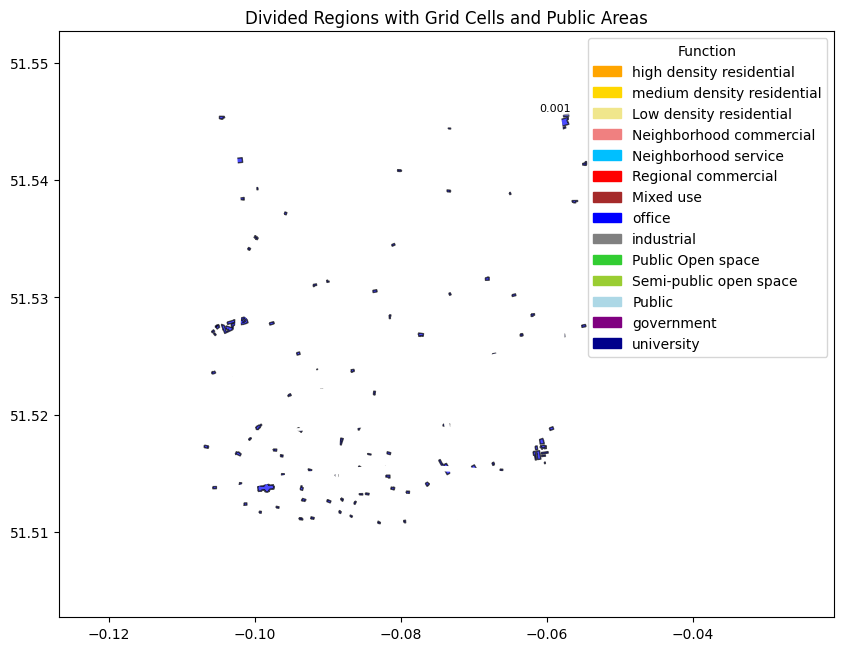

                                            geometry  \
0  POLYGON ((-0.05776 51.53509, -0.05776 51.53609...   
1  POLYGON ((-0.05777 51.53709, -0.05718 51.53709...   
2  POLYGON ((-0.05778 51.53809, -0.05718 51.53809...   
3  POLYGON ((-0.05778 51.53909, -0.05718 51.53909...   
4  POLYGON ((-0.05779 51.54003, -0.05779 51.54009...   

                   Function   Color  Area (km²)  \
0  high density residential  orange    0.006767   
1  high density residential  orange    0.007254   
2  high density residential  orange    0.007342   
3    Semi-public open space  orange    0.007430   
4    Semi-public open space  orange    0.007520   

                       Original Polygon Centroid  
0  POINT (-0.0556656544486325 51.54119810841534)  
1  POINT (-0.0556656544486325 51.54119810841534)  
2  POINT (-0.0556656544486325 51.54119810841534)  
3  POINT (-0.0556656544486325 51.54119810841534)  
4  POINT (-0.0556656544486325 51.54119810841534)  

Data types of the columns:
geometry              

In [48]:
# Step 4: Plot the divided regions with a legend for different functions
# Count the number of regions for each Function
function_counts = divided_regions_gdf_updated['Function'].value_counts()

# Print the total number of regions for each Function
print("Total number of regions for each Function:")
for function, count in function_counts.items():
    print(f"{function}: {count}")

# Optionally, you can also print the total number of regions
print(f"\nTotal number of regions: {len(divided_regions_gdf_updated)}")

# Check if the GeoDataFrame is empty
if divided_regions_gdf_updated.empty:
    print("Error: The GeoDataFrame is empty. No regions to plot.")
else:
    fig, ax = plt.subplots(figsize=(10, 10))

    color_map = {
        'high density residential': 'orange',
        'medium density residential': 'gold',
        'Low density residential': 'khaki',
        'Neighborhood commercial': 'lightcoral',
        'Neighborhood service': 'deepskyblue',
        'Regional commercial': 'red',
        'Mixed use': 'brown',
        'office': 'blue',
        'industrial': 'grey',
        'Public Open space': 'limegreen',
        'Semi-public open space': 'yellowgreen',
        'Public': 'lightblue',
        'government': 'purple',
        'university': 'darkblue',
    }

    # Plot the divided regions with different colors based on function
    for _, region in divided_regions_gdf_updated.iterrows():
        function = region['Function']
        color = color_map.get(function, 'gray')  # Default to gray if function is not in the map
        # Offset all regions inwards by 0.002
        offset_geometry = region.geometry.buffer(-0.002)
        ax.add_patch(plt.Polygon(np.array(offset_geometry.exterior.coords), color=color, alpha=1, edgecolor='black', linewidth=0))

    # Check if 'centroid' is defined
    if 'centroid' in locals():
        ax.text(centroid.x, centroid.y, f'{region["Area (km²)"]:.3f}', ha='center', va='center', fontsize=8, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    # Check if 'connected_paths' and 'colors' are defined
    if 'connected_paths' in locals() and 'colors' in locals():
        smooth_paths = []
        for i, path in enumerate(connected_paths):
            curve = bezier_curve(path)  # Use Bézier curve for smoothing
            
            # Store the smoothed path in the list
            smooth_paths.append(curve)

            color = colors[i % len(colors)]  # Use modulo to avoid index out of range
            ax.plot(curve[:, 0], curve[:, 1], color='white', linewidth=4, label=f'Path {i + 1}')

        # Create a list to hold the LineString geometries of the smooth paths
        line_strings = [LineString(curve) for curve in smooth_paths]

        # Calculate and plot the middle paths between consecutive curves
        middle_paths = []
        for i in range(len(smooth_paths) - 1):
            curve1 = smooth_paths[i]
            curve2 = smooth_paths[i + 1]
            
            # Compute the midpoints between the two curves
            midpoints = compute_midpoints(curve1, curve2)
            
            # Create a Bézier curve for the new middle path
            middle_path = bezier_curve(midpoints)
            middle_paths.append(middle_path)

            # Plot the middle path
            ax.plot(middle_path[:, 0], middle_path[:, 1], color='white', linewidth=2, label=f'Middle Path {i + 1}')

    # Plot landmark buildings as blue points, excluding train stations
    if 'df_building' in locals():
        df_building_filtered = df_building[df_building['type'] != 'train_station']
        df_building_filtered.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, alpha=0.7, label="Landmark Buildings", markersize=20)

    # Create a custom legend based on the color map
    legend_labels = [Patch(color=color, label=label) for label, color in color_map.items()]
    ax.legend(handles=legend_labels, title="Function", loc="upper right")

    # Set the title and show the plot
    plt.title("Divided Regions with Grid Cells and Public Areas")
    plt.show()

# Optionally, inspect the first few rows of the updated GeoDataFrame
print(divided_regions_gdf_updated.head())

# Print the data types of the columns
print("\nData types of the columns:")
print(divided_regions_gdf_updated.dtypes)

# Check for any null values
print("\nNull values in the GeoDataFrame:")
print(divided_regions_gdf_updated.isnull().sum())


Time step 1 completed.
Time step 2 completed.


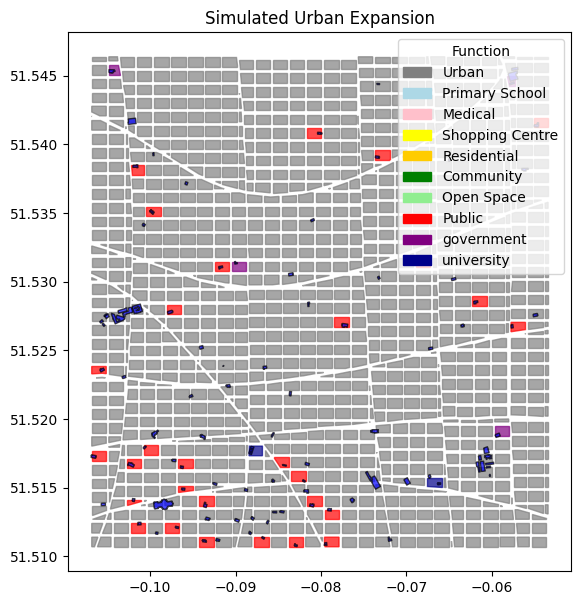

In [44]:
import numpy as np

# Set weights for each factor (you can adjust these based on your model)
alpha_1 = 0.4  # Weight for population growth rate
alpha_2 = 0.3  # Weight for economic attractiveness
alpha_3 = 0.1  # Weight for land cost
alpha_4 = 0.2  # Weight for proximity to urban areas
alpha_5 = 0.3  # Weight for infrastructure availability

# Random noise term
epsilon = np.random.normal(0, 0.01)

# Create columns to hold socio-economic factors (example initialization)
divided_regions_gdf_updated['PGR'] = np.random.uniform(0.01, 0.05, len(divided_regions_gdf_updated))  # Random population growth rate
divided_regions_gdf_updated['EA'] = np.random.uniform(0.1, 1, len(divided_regions_gdf_updated))  # Random economic attractiveness
divided_regions_gdf_updated['LC'] = np.random.uniform(50000, 200000, len(divided_regions_gdf_updated))  # Random land cost
divided_regions_gdf_updated['PA'] = np.random.uniform(0.1, 1, len(divided_regions_gdf_updated))  # Proximity to urban areas
divided_regions_gdf_updated['IA'] = np.random.uniform(0.1, 1, len(divided_regions_gdf_updated))  # Infrastructure availability

# Iterate over time steps (years or decades)
for t in range(2):  # Simulate 10 time steps
    # Loop over each region in the GeoDataFrame
    for idx, row in divided_regions_gdf_updated.iterrows():
        # Calculate the probability of becoming urban
        P_i = (alpha_1 * row['PGR'] + 
               alpha_2 * row['EA'] + 
               alpha_3 * (1 / row['LC']) + 
               alpha_4 * (1 / row['PA']) + 
               alpha_5 * row['IA'] + 
               epsilon)
        
        # Make a decision based on the probability (you can adjust the threshold)
        if P_i > 0.9:  # If probability is high enough, the region becomes urban
            divided_regions_gdf_updated.loc[idx, 'Function'] = 'Urban'
    
    # Optional: You can also visualize the grid at each step or print progress
    print(f"Time step {t + 1} completed.")

# After the simulation, you can plot the updated regions with the new 'Urban' regions
fig, ax = plt.subplots(figsize=(7, 7))
color_map = {
    'Urban': 'gray',
    'Primary School': 'lightblue',
    'Medical': 'pink',
    'Shopping Centre': 'yellow',
    'Residential': '#FFCC00',
    'Community': 'green',
    'Open Space': 'lightgreen',
    'Public': 'red',
    'government': 'purple',
    'university': 'darkblue',
}

# Plot the updated regions with colors based on the new 'Function'
for _, region in divided_regions_gdf_updated.iterrows():
    function = region['Function']
    color = color_map.get(function, 'gray')  # Default to gray if function is not in the map
    offset_geometry = region.geometry.buffer(-0.00015)  # Offset the region inwards by 0.001
    ax.add_patch(plt.Polygon(np.array(offset_geometry.exterior.coords), color=color, alpha=0.7, edgecolor='black',linewidth=1))

# Add a legend
legend_labels = [Patch(color=color, label=label) for label, color in color_map.items()]
ax.legend(handles=legend_labels, title="Function", loc="upper right")
# Plot landmark buildings as blue points, excluding train stations
df_building_filtered = df_building[df_building['type'] != 'train_station']
df_building_filtered.plot(ax=ax, color='blue', edgecolor='black', linewidth=1, alpha=0.7, label="Landmark Buildings", markersize=20)
# Set the title and show the plot
plt.title("Simulated Urban Expansion")
plt.show()
